In [1]:
%matplotlib inline
%config InlineBackend.figure_format='svg'
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
import os
from scipy.stats import linregress
# import chain

from operator import attrgetter
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from itertools import chain

from os.path import isfile, join

# if this is true, figures will be saved to your computer
saveFigures = False

# set size and dpi of figures
plt.rcParams['figure.figsize'] = (10, 6)
# plt.rcParams['figure.dpi'] = 600
plt.rcParams['figure.dpi'] = 300

asdf

In [2]:

# these functions are used in determining the type
# of data we are looking at (posthresh, neghold etc)
def is_increasing(L):
    return L[0] < L[len(L) - 1] and len(L) > 1
def is_decreasing(L):
    return L[0] > L[len(L) - 1] and len(L) > 1
def non_increasing(L):
    return all(x>=y for x, y in zip(L, L[1:]))
def non_decreasing(L):
    return all(x<=y for x, y in zip(L, L[1:]))
def monotonic(L):
    return non_increasing(L) or non_decreasing(L)
def average(array):
    return sum(array) / len(array)

# this will return the type of data you give it
# it takes an array of [voltages] and [currents] as arguments
def sort_into_side(voltage, current):
    if is_increasing(voltage) and is_increasing(current):
        return "posThresh"
    elif is_decreasing(voltage) and is_decreasing(current):
        return "posHold"
    elif is_decreasing(voltage) and is_increasing(current):
        return "negThresh"
    elif is_increasing(voltage) and is_decreasing(current):
        return "negHold"
    else: 
        print("error determining type of data. V: ", voltage, " I: ", current)

def get_rand_id():
    return np.random.randint(1000000000)

def find_index_of_closest_number_in_list(float_list, number):
    closest_index = 0  # Initialize with the index of the first value in the list
    closest_difference = abs(float_list[0] - number)  # Initialize with the absolute difference

    for i in range(1, len(float_list)):
        difference = abs(float_list[i] - number)
        if difference < closest_difference:
            closest_index = i
            closest_difference = difference

    return closest_index

def is_within_percentage_threshold(number, reference, percentage):
    # Calculate the allowable range based on the reference and percentage
    allowable_range = reference * (percentage / 100)
    # Check if the number is within the allowable range
    return abs(number - reference) <= allowable_range



asdf

In [3]:


class Graph: 
    def __init__(self, title, xlabel, ylabel, hlines, type_of_graph, data_to_graph, points, legends):
        self.title = title
        self.xlabel = xlabel
        self.ylabel = ylabel
        self.hlines = hlines
        self.type = type_of_graph
        self.data_to_graph = data_to_graph
        self.points = points
        self.legends = legends

        self.color_pool = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'brown', 'pink', 'olive', 'purple', 'gray', 'orange', 'blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'brown', 'pink', 'olive', 'purple', 'gray', 'orange','blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'brown', 'pink', 'olive', 'purple', 'gray', 'orange', 'blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'brown', 'pink', 'olive', 'purple', 'gray', 'orange', 'blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'brown', 'pink', 'olive', 'purple', 'gray', 'orange', 'blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'brown', 'pink', 'olive', 'purple', 'gray', 'orange','blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'brown', 'pink', 'olive', 'purple', 'gray', 'orange', 'blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'brown', 'pink', 'olive', 'purple', 'gray', 'orange', 'blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'brown', 'pink', 'olive', 'purple', 'gray', 'orange', 'blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'brown', 'pink', 'olive', 'purple', 'gray', 'orange','blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'brown', 'pink', 'olive', 'purple', 'gray', 'orange', 'blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'brown', 'pink', 'olive', 'purple', 'gray', 'orange' ]
        self.show()

    def show(self):
        
        fig, ax = plt.subplots()
        
        if self.type == "multiPlot":
            plt.xlabel(self.xlabel)
            plt.ylabel(self.ylabel)
            ax2 = ax.twinx()
            
        plt.title(self.title)
        plt.xlabel(self.xlabel, fontsize=14)
        plt.ylabel(self.ylabel, fontsize=14)
        plt.rcParams['font.size'] = 14  # Adjust the font size as needed
        # plt.xlim(0, 300)
        plt.ylim(5, 20)
        ax.grid()

  


        if self.type == "box":
            # print(self.data_to_graph)
            ax.boxplot(self.data_to_graph, labels=self.points)
        else:
            for i in range(len(self.data_to_graph) - 0):
                x = self.data_to_graph[i][0]
                y = self.data_to_graph[i][1]

                if x[0] > x[1] and "lnR vs 1000/T voltage" in self.title:
                    x = np.flip(x)
                    y = np.flip(y)

                color = self.color_pool[i]
                if self.type == "semilogy":
                    if len(self.legends) > 1:
                        print("self.legends[i]: ", self.legends)
                        print("data_to_graph: ", self.data_to_graph[i])
                        print("i: ", i)
                        # print("y: ", y)
        
                        ax.semilogy(x, y, color=color, label=self.legends, linewidth=4)
                        rectangle = patches.Rectangle((5, 1000), 1.66666, 1000000, linewidth=1, edgecolor='red', facecolor='none')
                        ax.add_patch(rectangle)


                        my_array_size = 5

                        x_fits_beginning = np.array(x[:my_array_size])
                        y_fits_beginning = np.array(y[:my_array_size])
                        # x_fits_end = np.array(x[-my_array_size:])
                        # y_fits_end = np.array(y[-my_array_size:])

                        # energy_level = ""
                        # slope, intercept, r_value, p_value, std_err = linregress(x_fits_end, y_fits_end)
                        # Ea = 1000 * slope * (0.000086)
                        # energy_level = "E_a: " + str(round(Ea, 3)) + " - "
                        # my_legend = self.legends[i] + energy_level
                        # line_of_best_fit_end = (slope * x_fits_end) + intercept

                        energy_level = ""
                        slope, intercept, r_value, p_value, std_err = linregress(x_fits_beginning, y_fits_beginning)
                        Ea = 1000 * slope * (0.000086)
                        energy_level = str(round(Ea, 3)) + " eV"
                        # my_legend = ""
                        my_legend = "y = " + str(slope) + "x" + str(intercept)
                        line_of_best_fit = (slope * x_fits_beginning) + intercept
                        ax.plot(x_fits_beginning, line_of_best_fit, color='red', linewidth=2 )

                        
                    else:
                        ax.semilogy(x, y, color=color, linewidth=4)

                elif self.type == "semilogx":
                    if len(self.legends) > 0:
                        ax.semilogx(x, y, color=color, label=self.legends)
                    else:
                        ax.semilogx(x, y, color=color)
                elif self.type == "loglog":
                    if len(self.legends) > 0:
                        ax.loglog(x, y, color=color, label=self.legends)
                    else:
                        ax.loglog(x, y, color=color)
                elif self.type == "multiPlot" and len(x) > 1:
                    ax.plot(x, y, color='blue', label=self.legends) 
                    

                    x2 = self.data_to_graph[i][3]
                    y2 = self.data_to_graph[i][4]

                    # print("x2, y2: ", x2, y2)

                    # print("0: ", y2[0])
                    # print("1: ", y2[1])
                    # print("2: ", y2[2])
                    # print("3: ", y2[3])
                    # print("4: ", y2[4])


                    # color = 'tab:red'
                    ax2.set_ylabel('max I - V', color="tab:red")
                    ax2.plot(x2, y2, color="red")
                    ax2.tick_params(axis='y', labelcolor="red")

                    # data_to_graph = [[t_posThresh, p_posThresh, " ", temperature_1, conductivity_1], [t_negThresh, np.abs(p_negThresh), " ", temperature_2, conductivity_2]]




                elif self.type == "plot" and len(x) > 1: 

                    # ax.plot(x, y, color=color)

                    # array_size = (int)(len(x) * 0.1)

                    # if array_size < 10:
                        # array_size = 10
                    
                    # my_array_size = 10

                    # x_fits_beginning = np.array(x[:my_array_size])
                    # y_fits_beginning = np.array(y[:my_array_size])
                    # x_fits_end = np.array(x[-my_array_size:])
                    # y_fits_end = np.array(y[-my_array_size:])

                    # energy_level = ""
                    # slope, intercept, r_value, p_value, std_err = linregress(x_fits_end, y_fits_end)
                    # Ea = 1000 * slope * (0.000086)
                    # energy_level = "E_a: " + str(round(Ea, 3)) + " - "
                    # my_legend = self.legends[i] + energy_level
                    # line_of_best_fit_end = (slope * x_fits_end) + intercept

                    # energy_level = ""
                    # slope, intercept, r_value, p_value, std_err = linregress(x_fits_beginning, y_fits_beginning)
                    # Ea = 1000 * slope * (0.000086)
                    # energy_level = str(round(Ea, 3)) + " eV"
                    # # my_legend = ""
                    # my_legend = my_legend + energy_level
                    # line_of_best_fit = (slope * x_fits_beginning) + intercept



                    
                    

                    try: 
                        ax.plot(x, y, color=color, label=self.legends[i], linewidth=4)   
                        ax.legend(loc='upper left')

                        if "lnR vs 1000/T voltage" in self.title and i == 1:
                            print("self.data_to_graph[i][0]: ", self.data_to_graph[i][0])
                            # rectangle = patches.Rectangle((5, 10), 1.66666, 2, linewidth=1, edgecolor='red', facecolor='none')
                            # ax.add_patch(rectangle)


                            index = next((i for i, num in enumerate(x) if num > 5), None)
                            my_array_size = index

                            x_fits_beginning = np.array(x[:my_array_size])
                            y_fits_beginning = np.array(y[:my_array_size])


                            energy_level = ""
                            slope, intercept, r_value, p_value, std_err = linregress(x_fits_beginning, y_fits_beginning)
                            Ea = 1000 * slope * (0.000086)
                            energy_level = str(round(Ea, 3)) + " eV"
                            print("activation energy: ", energy_level)

                            # # my_legend = ""
                            my_legend = "y = " + str(slope) + "x +" + str(intercept)
                            line_of_best_fit = (slope * x) + intercept
                            ax.plot(x, line_of_best_fit, color='red', label=energy_level, linewidth=2,)

                        
                    except Exception as e:
                        # Code to handle other exceptions
                        ax.plot(x, y, color=color)   


                    # ax.plot(x_fits_beginning, line_of_best_fit, color='red', linewidth=2)
                    # ax.plot(x_fits_end, line_of_best_fit_end, color='green', linewidth=2)
                    
                        
                        
                    
                elif self.type == "box":
                    ax.boxplot(x, y, color=color)
                    # ax.boxplot(x, y, color=color, label=self.legends[i])
                
                # ax.legend(loc="upper right", title="Legend Title")
            
                    
            for i in range(len(self.hlines)):
                ax.axhline(y = self.hlines[i], color = 'r', linestyle = '-')

            for i in range(len(self.points)):
                color_to_use = "red"
                # if self.points[i][2] == "posHold": 
                #     color_to_use = "blue"
                # if self.points[i][2] == "negThresh": 
                #     color_to_use = "green"
                # if self.points[i][2] == "negHold": 
                #     color_to_use = "orange"

                ax.plot(self.points[i][0], self.points[i][1], marker="o", markersize=10, markeredgecolor=color_to_use, markerfacecolor=color_to_use)
  
        












        ax2 = ax.twiny()

        new_tick_locations = np.array([4, 6, 8, 10, 12, 14, 16, 18])

        def tick_function(X):
            V = 1000 / X
            return ["%.0f" % z for z in V]

        ax2.set_xlim(ax.get_xlim())
        ax2.set_xticks(new_tick_locations)
        ax2.set_xticklabels(tick_function(new_tick_locations))
        ax2.set_xlabel('Temperature (K)')

        

        
        if saveFigures: 
            plt.savefig('figures/Nov15/' + self.title[:25] + '.png', bbox_inches='tight')
        plt.figure(get_rand_id())
        plt.show()

    # def fit_to_line(self):
    #     print("fdsa")

asdf

In [4]:
def read_file_data(data):
    # REMOVE BAD DATA: read all the data and remove the rows when we are very close to the max current
    rows_to_exclude = pd.read_csv(data.filePath, names=['Time (s)','Current (A)','Voltage (V)', 'Temperature (K)'], sep='\t',skiprows=1)
    data_from_file = rows_to_exclude.values
    rows_to_exclude.head()
    I_to_skip = data_from_file[:,1]
    # the cut off value for the max current is 0.9999999 * the highest current recorded in the file
    max_current = np.max(I_to_skip) * 0.9999999
    over_max_current_indexes = ((I_to_skip > max_current).nonzero())[0]
    # read the file again without the rows that have a current above the threshold
    df5 = pd.read_csv(data.filePath, names=['Time (s)','Current (A)','Voltage (V)', 'Temperature (K)'], sep='\t',skiprows=over_max_current_indexes)
    return df5.values

# takes the data and 
def createDataDictionary(data, start, stop):
    dI = np.gradient(data.I[start:stop])
    ddI = np.gradient(np.gradient(data.I[start:stop]))
    run_temp = np.average(data.temps[start:stop])
    run_temp_std = np.std(data.temps[start:stop])
    return {
        'time': data.time[start:stop],
        'I': data.I[start:stop],
        'R': data.R[start:stop],
        'dI': dI,
        'ddI': ddI,
        'V': data.V[start:stop],
        'P': data.I.copy()[start:stop] * data.V.copy()[start:stop],
        'temps': data.temps[start:stop],
        'temp': run_temp,
        'temp_std': run_temp_std,
        'type_of_data': sort_into_side(data.V[start:stop], data.I[start:stop]),
        'max_ddI': np.argmax(ddI),
    }

# counts how many posThresh, negThresh, posHold, or negHold data sets there are
def count_IV_curves(data):
    pos_thresh_IV_curve_count = 0
    pos_hold_IV_curve_count = 0
    neg_thresh_IV_curve_count = 0
    neg_hold_IV_curve_count = 0
    for IV_curve in data.IV_curves:
        if IV_curve['type_of_data'] == "posThresh":
            pos_thresh_IV_curve_count += 1
        if IV_curve['type_of_data'] == "negThresh":
            neg_thresh_IV_curve_count += 1
        if IV_curve['type_of_data'] == "posHold":
            pos_hold_IV_curve_count += 1
        if IV_curve['type_of_data'] == "negHold":
            neg_hold_IV_curve_count += 1
    return [pos_thresh_IV_curve_count, pos_hold_IV_curve_count, neg_thresh_IV_curve_count, neg_hold_IV_curve_count]


def find_regions_values_less_than_threshold(data, threshold):
    regions = []
    current_region = []

    for i, value in enumerate(data):
        if value < threshold:
            current_region.append(value)
        elif current_region:
            regions.append(current_region)
            current_region = []

    if current_region:
        regions.append(current_region)

    return regions


def find_regions_indices_less_than_threshold(data, threshold):
    regions = []
    current_region = []

    for i, value in enumerate(data):
        if value < threshold and value > -threshold:
            current_region.append(i)
        elif current_region:
            regions.append(current_region)
            current_region = []

    if current_region:
        regions.append(current_region)

    return regions


def find_regions_and_average(data, threshold):
    regions = []
    current_region = []

    for i, value in enumerate(data):
        if value < threshold:
            current_region.append(value)
        elif current_region:
            regions.append({
                'values': current_region,
                'average': np.mean(current_region)
            })
            current_region = []

    if current_region:
        regions.append({
            'values': current_region,
            'average': np.mean(current_region)
        })

    return regions

In [5]:
# this will take a file name and
# get all of the meaningful stuff out of it
class DataFile:
    def __init__(self, file_path):
        self.filePath = file_path # path to the data file
        self.get_file_name_from_path() # takes the path and isolates the file name
        self.get_device_number_from_name() # reads the device number from the filename
        self.get_sample_number_from_name() # reads the sample number from the filename
        self.read_all_data() # reads all the data and saves it
        try:
            self.break_all_data_into_IV_curves()
            self.get_temp_range()
        except Exception as e:
            # Code to handle other exceptions
            print(f"An error occurred: {e} ", self.file_name)
        # self.count_IV_curve_types()

    def get_file_name_from_path(self):
        self.file_name = self.filePath.split("summerData/")[1]
        # print(self.file_name)

    def get_device_number_from_name(self):
        self.device_number = self.file_name.split("_")[4]

    def get_sample_number_from_name(self):
        self.sample_number = self.file_name.split("_")[3]

    # reads all the data using the filename and saves each
    def read_all_data(self):

        data = read_file_data(self)
        indices_greater_than_01 = [index for index, value in enumerate(data[:,1]) if value >= 0.01]
        
        interval = 1
        # time = np.arange(0, len(data[:,0])) * interval

        time = data[:,0]
        current = data[:,1]
        voltage = data[:,2]
        temps = data[:,3]

        self.time = np.array([time[i] for i in range(len(time)) if i not in indices_greater_than_01])
        self.I = np.array([current[i] for i in range(len(current)) if i not in indices_greater_than_01])
        self.V = np.array([voltage[i] for i in range(len(voltage)) if i not in indices_greater_than_01])
        self.temps = np.array([temps[i] for i in range(len(temps)) if i not in indices_greater_than_01])
        self.R = self.V / self.I

        self.number_of_data_points = len(data[:,0])
        
    # make IV graph of all data
    def graph_all_data(self):
        fig, ax = plt.subplots()
        plt.title("All Data")
        plt.xlabel("Voltage (V)")
        plt.ylabel("Current (A)")
        ax.grid()
        ax.semilogy(self.V, self.I, color='black')

    # takes all the data and breaks it into segments. Each segment is a posThresh, negThresh, posHold, negHold
    def break_all_data_into_IV_curves(self):
        # get the index of every "0.000" value in the voltage array
        self.all_zero_indexes = np.where(self.V == 0.0)[0]

        # removing the first and last 4 "0.000" data points reduces the number of crashes
        self.all_zero_indexes = self.all_zero_indexes[4:]
        self.all_zero_indexes = self.all_zero_indexes[:-4]

        # the data between two "0.000" points will be stored here as a list
        self.IV_curves = []

        # gets the following data out of the file: 'I' 'R' 'dI' 'ddI' 'V' 'temps' 'temp' 'temp_std' 'type_of_data' 'max_ddI' and stores it in a dictionary
        # the positive and negative voltage data will be stored in separate dictionary enteries
        for i in range(len(self.all_zero_indexes) - 1):
            start = self.all_zero_indexes[i] # where to start the list
            stop = (int)(start + ((self.all_zero_indexes[i+1] - start) / 2)) # where to end the list. This is the first half of the data which is the positive side
            self.IV_curves.append(createDataDictionary(self, start, stop))

            start = (int)(self.all_zero_indexes[i] + ((self.all_zero_indexes[i+1] - start) / 2)) # where to start the list. Second half of the data
            stop = self.all_zero_indexes[i+1] # where to end the list
            self.IV_curves.append(createDataDictionary(self, start, stop))

        # counts the number of total IV curves in the data
        self.number_of_IV_curves = (len(self.IV_curves) - 1) * 1

    # gets the temp range of the data
    def get_temp_range(self):
        # store all temperature data 
        all_temps = []
        for i in range(0, self.number_of_IV_curves):
            temp = self.IV_curves[i]['temp']
            all_temps.append(temp)
        self.all_temps = all_temps

        # store the temperature range in all the data
        min_temp = all_temps[5] 
        max_temp = all_temps[len(all_temps) - 5 ]
        self.temp_range = [min_temp, max_temp]

    # counts the number of each type of IV curves in the data
    def count_IV_curve_types(self):
        iv_curve_types = count_IV_curves(self)
        print("pos_thresh_IV_curve_count: ", iv_curve_types[0])
        print("pos_hold_IV_curve_count: ", iv_curve_types[1])
        print("neg_thresh_IV_curve_count: ", iv_curve_types[2])
        print("neg_hold_IV_curve_count: ", iv_curve_types[3])

    # gets data for graph of IV curves with dots at V_thresh and V_hold
    def get_IV_curve_data(self, index):
        
        # this is where the IV data, V_thresh and V_hold will be stored
        data_to_graph = []
        points_to_graph = []

        # combine 4 "IV" curves to make one full period of a voltage sweep
        for i in range(4):
            voltage = self.IV_curves[index + i]['V']
            current = self.IV_curves[index + i]['I']
            data_to_graph.append([voltage, current])

            # depending on the direction of the voltage sweep, make slight asjustments to find the V_thresh and V_hold
            fine_tune = 0
            type_of_data = self.IV_curves[index + i]['type_of_data']
            if type_of_data == "posThresh":
                fine_tune = 1
            if type_of_data == "negThresh":
                fine_tune = 1
            if type_of_data == "posHold":
                fine_tune = -2
            if type_of_data == "negHold":
                fine_tune = -2
            
            index_to_graph = self.IV_curves[index + i]['max_ddI'] + fine_tune # index of V_thresh or V_hold for the given IV_curve
            points_to_graph.append([voltage[index_to_graph], current[index_to_graph], type_of_data])

        # graph title
        title =  self.file_name.split("23_")[1][:-4] + " " + str(index) + "_" + str((self.number_of_IV_curves))
    
        return [
            title,              # title
            "Voltage (V)",      # xlabel
            "Current (A)",      # ylabel
            [],                 # hlines
            "semilogy",         # type of graph
            data_to_graph,      # data to graph
            points_to_graph,    # points
            [],                 #legends
        ]
    
    # gets IV curve data at a certain temperature
    def get_IV_curve_data_by_temp(self, temp):
        
        # this is where the IV data, V_thresh and V_hold will be stored
        data_to_graph = []
        points_to_graph = []

        # find the clostest temperature in the data to the one I want to graph
        index = find_index_of_closest_number_in_list(self.all_temps[0:-5], temp)

        # combine 4 "IV" curves to make one full period of a voltage sweep
        for i in range(4):
            voltage = self.IV_curves[index + i]['V']
            current = self.IV_curves[index + i]['I']
            data_to_graph.append([voltage, current])

            fine_tune = 0
            type_of_data = self.IV_curves[index + i]['type_of_data']
            if type_of_data == "posThresh":
                fine_tune = 1
            if type_of_data == "negThresh":
                fine_tune = 1
            if type_of_data == "posHold":
                fine_tune = -2
            if type_of_data == "negHold":
                fine_tune = -2
            
            index_to_graph = self.IV_curves[index + i]['max_ddI'] + fine_tune # index of V_thresh or V_hold for the given IV_curve
            points_to_graph.append([voltage[index_to_graph], current[index_to_graph], type_of_data])

        # graph title
        title_temp = str(round(self.IV_curves[index]['temp'])) + "K "
        title = "IVcurve_" + str(index) + title_temp

        return [
            title_temp,              # title
            "Voltage (V)",      # xlabel
            "Current (A)",      # ylabel
            [],                 # hlines
            "semilogy",         # type of graph
            data_to_graph,      # data to graph
            points_to_graph,    # points
            [],                 #legends
        ]

    # uses the function that I defined above to graph an IV curve with the V_hold and V_thresh points
    def graph_IV_curve(self, index):
        ic_curve_data = self.get_IV_curve_data(index)
        the_graph = Graph(
            ic_curve_data[0],   # title
            ic_curve_data[1],   # xlabel
            ic_curve_data[2],   # ylabel
            ic_curve_data[3],   # hlines
            ic_curve_data[4],   # type of graph
            ic_curve_data[5],   # data to graph
            ic_curve_data[6],   # points
            ic_curve_data[7],   #legends
        )

    # make multiple IV curve on separate graphs
    def graph_IV_curves(self, number_of_graphs):
        for x in range(0, number_of_graphs):
            i = (int)(((self.number_of_IV_curves) / number_of_graphs) * x)
            self.graph_IV_curve(i)

    # stacks multiple IV curves on the same graph. they are evenly spaced by temperature
    def overlay_IV_curves(self, number_of_graphs):

        min_temp = self.temp_range[0]
        max_temp = self.temp_range[1]
        temp_step = (max_temp - min_temp) / (number_of_graphs) # temperature spacing between each graph

        # store all the data in iv_curves
        iv_curves = []
        temp_to_graph = min_temp
        for x in range(0, number_of_graphs):
            iv_curves.append(self.get_IV_curve_data_by_temp(temp_to_graph))
            temp_to_graph = temp_to_graph + temp_step

        # set up the graph
        title = "Sam " + self.file_name.split("_Sam")[1][:-4] + iv_curves[0][0] + iv_curves[1][0] + iv_curves[2][0] + iv_curves[3][0] + iv_curves[4][0]
        xlabel = iv_curves[0][1]
        ylabel = iv_curves[0][2]
        hlines = iv_curves[0][3]
        type_of_graph = iv_curves[0][4]
        data_to_graph = iv_curves[0][5] + iv_curves[1][5] + iv_curves[2][5] + iv_curves[3][5] + iv_curves[4][5]
        points = iv_curves[0][6] + iv_curves[1][6] + iv_curves[2][6] + iv_curves[3][6] + iv_curves[4][6]
        legends = [iv_curves[0][0], iv_curves[1][0], iv_curves[2][0], iv_curves[3][0], iv_curves[4][0]]

        # make the graph
        the_graph = Graph(
            title,
            xlabel,
            ylabel,
            hlines,
            type_of_graph,
            data_to_graph,
            points,
            legends,
        )

    # make graph of percent diff resistance at 0.5 V
    def graph_voltage_vs_resistance_half_volt(self):
        data_to_graph = []

        lowest_voltage_resistance = []
        second_lowest_voltage_resistance = []

        neg_lowest_voltage_resistance = []
        neg_second_lowest_voltage_resistance = []

        # store them as easily readable names
        currents = self.I
        voltages = self.V
        resistances = self.R
        temps = self.temps

        # go through all voltages and save the resistance and temp when the voltage is close to 0.5 V
        for index in range(len(self.V)):
            
            if is_within_percentage_threshold(voltages[index], 0.5, 5) or is_within_percentage_threshold(-1 * voltages[index], 0.5, 5): # 5% tolerance on voltage values because the data can be noisy
                if index + 2 < len(voltages) and index - 2 > 0:
                    if voltages[index] > 0:
                        lowest_voltage_resistance.append([temps[index], voltages[index], resistances[index]])
                        second_lowest_voltage_resistance.append([temps[index + 1], voltages[index + 1], resistances[index + 1]])

                    if voltages[index] < 0:
                        neg_lowest_voltage_resistance.append([temps[index], voltages[index], resistances[index]])
                        neg_second_lowest_voltage_resistance.append([temps[index - 1], voltages[index - 1], resistances[index - 1]])

        
        xAxis = []
        yAxis = []

        xAxis2 = []
        yAxis2 = []

        for index in range(len(lowest_voltage_resistance)):
            temp1 = lowest_voltage_resistance[index][0]
            temp2 = second_lowest_voltage_resistance[index][0]

            resistance1 = lowest_voltage_resistance[index][2]
            resistance2 = second_lowest_voltage_resistance[index][2]

            percent_diff = abs((resistance1 - resistance2) / ((resistance1 + resistance2) / 2)) * 100

            # if index > 50:
            xAxis.append(temp1)
            yAxis.append(percent_diff)

        for index in range(len(neg_lowest_voltage_resistance)):
            temp1 = neg_lowest_voltage_resistance[index][0]
            temp2 = neg_second_lowest_voltage_resistance[index][0]

            resistance1 = neg_lowest_voltage_resistance[index][2]
            resistance2 = neg_second_lowest_voltage_resistance[index][2]

            percent_diff = abs((resistance1 - resistance2) / ((resistance1 + resistance2) / 2)) * 100

            # if index > 50:
            xAxis2.append(temp1)
            yAxis2.append(percent_diff)

        data_to_graph = [[xAxis, yAxis], [xAxis2, yAxis2]]
        legends = ["pos", "neg"]




        # print("lowest_voltage_resistance: ", lowest_voltage_resistance)
        # print("second_lowest_voltage_resistance: ", second_lowest_voltage_resistance)
        # print("neg_lowest_voltage_resistance: ", neg_lowest_voltage_resistance)
        # print("neg_second_lowest_voltage_resistance: ", neg_second_lowest_voltage_resistance)
        # print("data_to_graph: ", data_to_graph)
        
        the_graph = Graph(
        self.file_name[19:-4] +  " percent diff resistance half volt",   # title
        "Temp (K)",                             # xlabel
        "percent diff",                          # ylabel
        [],                                     # hlines
        "plot",                             # type of graph
        data_to_graph,                          # data to graph
        [],                                     # points
        legends                                  # legends
        )






    def graph_lowest_voltage_resistance(self): 
        data_to_graph = []
        legends = ["pos", "neg"]

        lowest_voltage_resistance = []
        second_lowest_voltage_resistance = []

        neg_lowest_voltage_resistance = []
        neg_second_lowest_voltage_resistance = []

        # for IV_curve in self.IV_curves:
        currents = self.I
        voltages = self.V
        resistances = self.R
        temps = self.temps

        for index in range(len(self.V)):
            if voltages[index] == 0: 
                if index + 2 < len(voltages) and index - 2 > 0:
                    if voltages[index + 1] > 0:
                        # data_to_graph.append([voltages[index + 1]])
                        lowest_voltage_resistance.append([temps[index + 1], voltages[index + 1], resistances[index + 1]])
                        second_lowest_voltage_resistance.append([temps[index + 2], voltages[index + 2], resistances[index + 2]])

                    if voltages[index - 1] < 0:
                        # data_to_graph.append([voltages[index - 1]])
                        neg_lowest_voltage_resistance.append([temps[index - 1], voltages[index - 1], resistances[index - 1]])
                        neg_second_lowest_voltage_resistance.append([temps[index - 2], voltages[index - 2], resistances[index - 2]])


        xAxis = []
        yAxis = []

        xAxis2 = []
        yAxis2 = []

        for index in range(len(lowest_voltage_resistance)):
            temp1 = lowest_voltage_resistance[index][0]
            temp2 = second_lowest_voltage_resistance[index][0]

            resistance1 = lowest_voltage_resistance[index][2]
            resistance2 = second_lowest_voltage_resistance[index][2]

            percent_diff = abs((resistance1 - resistance2) / ((resistance1 + resistance2) / 2)) * 100

            # if index > 50:
            xAxis.append(temp1)
            yAxis.append(percent_diff)

        for index in range(len(neg_lowest_voltage_resistance)):
            temp1 = neg_lowest_voltage_resistance[index][0]
            temp2 = neg_second_lowest_voltage_resistance[index][0]

            resistance1 = neg_lowest_voltage_resistance[index][2]
            resistance2 = neg_second_lowest_voltage_resistance[index][2]

            percent_diff = abs((resistance1 - resistance2) / ((resistance1 + resistance2) / 2)) * 100

            # if index > 50:
            xAxis2.append(temp1)
            yAxis2.append(percent_diff)

        data_to_graph = [[xAxis, yAxis], [xAxis2, yAxis2]]




        # print("lowest_voltage_resistance: ", lowest_voltage_resistance)
        # print("second_lowest_voltage_resistance: ", second_lowest_voltage_resistance)
        # print("neg_lowest_voltage_resistance: ", neg_lowest_voltage_resistance)
        # print("neg_second_lowest_voltage_resistance: ", neg_second_lowest_voltage_resistance)
        # print("data_to_graph: ", data_to_graph)
        
        the_graph = Graph(
        self.file_name[19:-4] +  " temp vs percent diff resistance ",   # title
        "Temp (K)",                             # xlabel
        "percent diff",                          # ylabel
        [],                                     # hlines
        "plot",                             # type of graph
        data_to_graph,                          # data to graph
        [],                                     # points
        legends                                  # legends
        )

                




        



    def graph_dR_vs_I(self):

        data_to_graph = []
        data_to_graph2 = []
        data_to_graph3 = []
        data_to_graph_avg = []
        data_to_graph_avg2 = []
        legends = []

        current_data = []
        dR_data = []
        threshold_index = []

        i = 0
        for IV_curve in self.IV_curves:
            i += 1
            currents = np.abs(IV_curve['I'])
            # voltages = IV_curve['V']

            resistance = np.abs(IV_curve['R'])
            temp = np.abs(IV_curve['temp'])

            # new_R = voltages / currents

            # xAxis.append(np.log10(currents))
            # yAxis.append(new_R)
            if i % 3 == 0:
                dR = np.gradient(resistance)
                # current_data.append(np.log10(currents))
                # dR_data.append(r)

                data = [currents, dR]
                data_to_graph.append(data)

                data = [currents, dR]
                data_to_graph3.append(data)

                # small_r_data = [value for index, value in enumerate(r) if value < 0.1 and value > -0.1]
                # small_I_data_indices = [index for index, value in enumerate(r) if value < 0.1 and value > -0.1]
                
                # find_regions_indices_less_than_threshold
                # def find_regions_values_less_than_threshold(data, threshold):
                
                small_r_data_indices = find_regions_indices_less_than_threshold(dR, 0.1)
                # small_r_data = find_regions_values_less_than_threshold(dR, 0.1)

                new_r = []
                new_r_avg = []
                new_I = []

                for region in small_r_data_indices:
                    for item in range(0, len(region)):
                        resistance2 = dR[region[item]]
                        resistance3 = resistance[region[item]]
                        # print(resistance3)
                        current = currents[region[item]]

                        new_r.append(resistance2)
                        new_r_avg.append(resistance3)
                        new_I.append(current)
                    
                    data_to_graph2.append([new_I, new_r])
                    data_to_graph_avg.append([temp, np.mean(new_r_avg)])
                    data_to_graph_avg2.append([(1000 / temp), np.mean(new_r_avg)])
            
                        # print("resistance: ", resistance, "current: ", current)

                        # current = 
                        # data = [np.log10(currents), r]
                        # comment: 
                    # end for
                    # print("region: ", region)
                    # comment: 
                # end for

                # print("small_r_data_indices: ", small_r_data_indices)
                # small_r_data = for
                # small_I_data = [currents[index] for index in small_I_data_indices]
                # print("small_I_data: ", small_I_data)

                # if (len(small_r_data) > 0):
                #     print("len small_I_data: ", len(small_I_data))
                #     print("len small_r_data: ", len(small_r_data))
                #     data_to_graph2.append([np.log10(small_I_data), small_r_data])




                    # # Example usage:
                    # data_list = [0.05, 0.2, 0.3, 0.08, 0.05, 0.02, 0.15, 0.09, 0.25, 0.3, 0.05]
                    # threshold_value = 0.1

                    # result = find_regions_less_than_threshold(data_list, threshold_value)
                    # print("Values in regions where values are less than", threshold_value, ":", result)

                    # output: 
                    # Values in regions where values are less than 0.1 : [[0.05], [0.08, 0.05, 0.02], [0.09], [0.05]]






                # Find elements less than 0.1 and greater thatn -0.1
                # small_r_data = []
                
                # data_to_graph2.append([x for x in data if -0.1 < x[1] < 0.1])
        
        # current_list = data_to_graph[0][0]
        # resistance_list = data_to_graph[0][1]

        # filtered_data = [
        #     [current, resistance]
        #     for current, resistance in zip(current_list, resistance_list)
        #     if resistance < 0.1
        # ]

        
        # data_to_graph2.append([x for x in data if -0.1 < x[1] < 0.1])

                # data_to_graph2.append([np.log10(currents), threshold_index])

        # for index in range(len(threshold_index)):
        #     for data_set_index in range(len(dR_data)):
        #         r = np.gradient(np.log10(resistance))
        #         current = current_data[]
        #         data_to_graph2.append([data_to_graph[index][data_set_index][0], data_to_graph[index][data_set_index]])
                
        # data_to_graph2 = [data_list[index] for index in threshold_index]

        print("data_to_graph_avg: ", data_to_graph_avg)
        
        

        the_graph = Graph(
            self.file_name[19:-4] +  " current vs dR loglog",   # title
            "I (A)",                             # xlabel
            "dR (ohm)",                          # ylabel
            [],                                     # hlines
            "loglog",                             # type of graph
            data_to_graph,                          # data to graph
            [],                                     # points
            legends                                  # legends
        )

        the_graph3 = Graph(
            self.file_name[19:-4] +  " current vs dR semilogy",   # title
            "I (A)",                             # xlabel
            "dR (ohm)",                          # ylabel
            [],                                     # hlines
            "semilogx",                             # type of graph
            data_to_graph3,                          # data to graph
            [],                                     # points
            legends                                  # legends
        )


        the_graph4 = Graph(
            self.file_name[19:-4] +  " current vs dR less than 0.1 loglog semilogx",   # title
            "I (A)",                             # xlabel
            "dR (ohm)",                          # ylabel
            [],                                     # hlines
            "semilogx",                             # type of graph
            data_to_graph2,                          # data to graph
            [],                                     # points
            legends                                  # legends
        )

        the_graph5 = Graph(
            self.file_name[19:-4] +  " temp vs r less than 0.1 avg semilogx",   # title
            "Temp (K)",                             # xlabel
            "Resistance (ohm)",                          # ylabel
            [],                                     # hlines
            "semilogx",                             # type of graph
            [],                          # data to graph
            data_to_graph_avg,                                     # points
            legends                                  # legends
        )

        the_graph6 = Graph(
            self.file_name[19:-4] +  " 1000/T vs ln(r) less than 0.1 avg",   # title
            "1000/T (1/K)",                             # xlabel
            "ln(R) (ohm)",                          # ylabel
            [],                                     # hlines
            "plot",                             # type of graph
            [],                          # data to graph
            data_to_graph_avg2,                                     # points
            legends                                  # legends
        )




    def graph_DV_DI_vs_I(self):
        # xAxis = []
        # yAxis = []

        data_to_graph = []
        data_to_graph2 = []
        legends = []

        i = 0
        for IV_curve in self.IV_curves:
            i += 1
            currents = (IV_curve['I'])
            # voltages = IV_curve['V']

            resistance = (IV_curve['R'])

            # new_R = voltages / currents

            # xAxis.append(np.log10(currents))
            # yAxis.append(new_R)
            if i % 10 == 0:
                data_to_graph.append([currents, resistance])
                data_to_graph2.append([currents, resistance])

        
        

        the_graph = Graph(
            self.file_name[19:-4] +  " log10_I vs R ",   # title
            "Current (A)",                             # xlabel
            "Resistance (ohm)",                          # ylabel
            [],                                     # hlines
            "semilogx",                             # type of graph
            data_to_graph,                          # data to graph
            [],                                     # points
            legends                                  # legends
        )

        the_graph2 = Graph(
            self.file_name[19:-4] +  " I vs R",   # title
            "Current (A)",                             # xlabel
            "Resistance (ohm)",                          # ylabel
            [],                                     # hlines
            "plot",                             # type of graph
            data_to_graph2,                          # data to graph
            [],                                     # points
            legends                                  # legends
        )




    def graph_time_vs_I(self):
        data_to_graph = []
        legends = []

        i = 0
        for IV_curve in self.IV_curves:
            i += 1
            currents = IV_curve['V']
            temp = IV_curve['temp']

            time = IV_curve['time'].astype(float)
            print("time: ", time)
            timeGradient = np.gradient(time)

            if is_within_percentage_threshold(temp, 230, 1):


                # print("temp: ", temp, time)

            # new_R = voltages / currents

            # xAxis.append(np.log10(currents))
            # yAxis.append(new_R) (number, reference, percentage):
                data_to_graph.append([currents, timeGradient])

        
        

        the_graph = Graph(
            self.file_name[19:-4] +  " time vs curent",   # title
            "voltage (A)",                             # xlabel
            "time (s)",                          # ylabel
            [],                                     # hlines
            "plot",                             # type of graph
            data_to_graph,                          # data to graph
            [],                                     # points
            legends                                  # legends
        )
        





    def graph_r_vs_log_i(self):
        xAxis = []
        yAxis = []

        xAxis2 = []
        yAxis2 = []

        tempXAxis = []
        tempYAxis = []
        tempTemps = []

        for IV_curve in self.IV_curves:
            current = IV_curve['I']
            resistance = IV_curve['R']
            temp = IV_curve['temps']
            tempXAxis.append(current)
            tempYAxis.append(resistance)
            tempTemps.append(temp)

        first_ten_temps = []    
        second_ten_temps = []    

        for i in range(0, 50):
            # if i % 5 == 0:
            for index in range(len(tempXAxis[i])):
                xAxis.append((tempXAxis[i][index]))
                yAxis.append((np.abs(tempYAxis[i][index])))
                first_ten_temps.append(tempTemps[i][index])
        
        for i in range(50, 100):
            # if i % 5 == 0:
            for index in range(len(tempXAxis[i])):
                xAxis2.append((tempXAxis[i][index]))
                yAxis2.append((np.abs(tempYAxis[i][index])))
                second_ten_temps.append(tempTemps[i][index])


        data_to_graph = [[xAxis, yAxis], [xAxis2, yAxis2]]
        legends = ["first 10 temps ≈" + str(round(np.average(first_ten_temps))) + " K", "second 10 temps ≈" + str(round(np.average(second_ten_temps))) + " K"]

        the_graph = Graph(
            self.file_name[19:-4] +  " log10_I vs R",   # title
            "Log10(I) (A)",                             # xlabel
            "Resistance (ohm)",                          # ylabel
            [],                                     # hlines
            "semilogx",                             # type of graph
            data_to_graph,                          # data to graph
            [],                                     # points
            legends                                  # legends
        )







    def graph_log_r_vs_voltage(self):
        xAxis = []
        yAxis = []

        tempXAxis = []
        tempYAxis = []

        for IV_curve in self.IV_curves:
            resistance = IV_curve['R']
            voltage = IV_curve['V']
            tempXAxis.append(voltage)
            tempYAxis.append(resistance)

        for i in range(len(tempXAxis) - 1):
            if i % 5 == 0:
                for index in range(len(tempXAxis[i])):
                    xAxis.append(tempXAxis[i][index])
                    yAxis.append(np.log10(np.abs(tempYAxis[i][index])))


        data_to_graph = [[xAxis, yAxis]]

        # print("data_to_graph: ", data_to_graph)
        legends = []

        # print(xAxis)

        the_graph = Graph(
            self.file_name[19:-4] +  " v vs ln_R",   # title
            "Voltage (V)",                             # xlabel
            "Ln(R) (ohm)",                          # ylabel
            [],                                     # hlines
            "plot",                             # type of graph
            data_to_graph,                          # data to graph
            [],                                     # points
            legends                                  # legends
        )




    

    def graph_R_vs_T_constant_P(self):
        xAxis = []
        yAxis = []

        xAxis2 = []
        yAxis2 = []

        xAxis3 = []
        yAxis3 = []

        xAxis4 = []
        yAxis4 = []

        xAxis5 = []
        yAxis5 = []


        for IV_curve in self.IV_curves:
            power = IV_curve['P']
            resistance = IV_curve['R']
            temps = IV_curve['temps']

            powerIndex = find_index_of_closest_number_in_list(power, 0.0001)
            if is_within_percentage_threshold(power[powerIndex], 0.0001, 2.5):
                xAxis.append(1000 / temps[powerIndex])
                yAxis.append(np.log(resistance[powerIndex]))

            powerIndex = find_index_of_closest_number_in_list(power, 0.00001)
            if is_within_percentage_threshold(power[powerIndex], 0.00001, 2.5):
                xAxis2.append(1000 / temps[powerIndex])
                yAxis2.append(np.log(resistance[powerIndex]))

            powerIndex = find_index_of_closest_number_in_list(power, 0.000005)
            if is_within_percentage_threshold(power[powerIndex], 0.000005, 2.5):
                xAxis3.append(1000 / temps[powerIndex])
                yAxis3.append(np.log(resistance[powerIndex]))

            powerIndex = find_index_of_closest_number_in_list(power, 0.0000025)
            if is_within_percentage_threshold(power[powerIndex], 0.0000025, 2.5):
                xAxis4.append(1000 / temps[powerIndex])
                yAxis4.append(np.log(resistance[powerIndex]))

            powerIndex = find_index_of_closest_number_in_list(power, 0.000001)
            if is_within_percentage_threshold(power[powerIndex], 0.000001, 2.5):
                xAxis5.append(1000 / temps[powerIndex])
                yAxis5.append(np.log(resistance[powerIndex]))


        data_to_graph = [[xAxis, yAxis], [xAxis2, yAxis2], [xAxis3, yAxis3], [xAxis4, yAxis4], [xAxis5, yAxis5]]
        legends = ["0.0001 W", "0.00001 W", "0.000005 W", "0.0000025 W", "0.000001 W"]
        the_graph = Graph(
            self.file_name[19:-4] +  " ln(R) vs 1000/T constant P",   # title
            "1000 / Temperature",                             # xlabel
            "ln(R) (ohm)",                          # ylabel
            [],                                     # hlines
            "plot",                             # type of graph
            data_to_graph,                          # data to graph
            [],                                     # points
            legends                                  # legends
        )









    def graph_voltage_vs_temp_type(self):
        xAxis = []
        yAxis = []

        xAxis2 = []
        yAxis2 = []

        xAxis3 = []
        yAxis3 = []

        xAxis4 = []
        yAxis4 = []

        for IV_curve in self.IV_curves:
            if IV_curve['type_of_data'] == "posThresh":
                temp = IV_curve['temps'][IV_curve['max_ddI']]
                resistance = IV_curve['R'][IV_curve['max_ddI']]
                voltage = IV_curve['V'][IV_curve['max_ddI']]
                xAxis.append(temp)
                yAxis.append(abs(voltage))

        for IV_curve in self.IV_curves:
            if IV_curve['type_of_data'] == "negThresh":
                temp = IV_curve['temps'][IV_curve['max_ddI']]
                resistance = IV_curve['R'][IV_curve['max_ddI']]
                voltage = IV_curve['V'][IV_curve['max_ddI']]
                xAxis2.append(temp)
                yAxis2.append(abs(voltage))

        # for IV_curve in self.IV_curves:
        #     if IV_curve['type_of_data'] == "posHold":
        #         temp = IV_curve['temps'][IV_curve['max_ddI']]
        #         resistance = IV_curve['R'][IV_curve['max_ddI']]
        #         voltage = IV_curve['V'][IV_curve['max_ddI']]
        #         xAxis3.append(temp)
        #         yAxis3.append(abs(voltage))

        # for IV_curve in self.IV_curves:
        #     if IV_curve['type_of_data'] == "negHold":
        #         temp = IV_curve['temps'][IV_curve['max_ddI']]
        #         resistance = IV_curve['R'][IV_curve['max_ddI']]
        #         voltage = IV_curve['V'][IV_curve['max_ddI']]
        #         xAxis4.append(temp)
        #         yAxis4.append(abs(voltage))

        # data_to_graph = [[xAxis, yAxis], [xAxis2, yAxis2], [xAxis3, yAxis3], [xAxis4, yAxis4]]
        data_to_graph = [[xAxis, yAxis], [xAxis2, yAxis2]]
        # legends = ["posThresh - " + str(len(xAxis)), "negThresh - " + str(len(xAxis2)), "posHold - " + str(len(xAxis3)), "negHold - " + str(len(xAxis4))]
        legends = ["posThresh", "negThresh"]

        # print(xAxis)

        the_graph = Graph(
            self.file_name[19:-4] +  " Threshold V vs T",   # title
            "Temperature (K)",                             # xlabel
            "Voltage (V)",                          # ylabel
            [],                                     # hlines
            "plot",                             # type of graph
            data_to_graph,                          # data to graph
            [],                                     # points
            legends                                  # legends
        )


    def graph_voltage_vs_resistance(self):
        xAxis = []
        yAxis = []

        xAxis2 = []
        yAxis2 = []

        xAxis3 = []
        yAxis3 = []

        xAxis4 = []
        yAxis4 = []

        for IV_curve in self.IV_curves:
            if IV_curve['type_of_data'] == "posThresh":
                temp = IV_curve['temp']
                resistance = IV_curve['R'][IV_curve['max_ddI']]
                voltage = IV_curve['V'][IV_curve['max_ddI']]
                xAxis.append(resistance)
                yAxis.append(abs(voltage))

        for IV_curve in self.IV_curves:
            if IV_curve['type_of_data'] == "negThresh":
                temp = IV_curve['temp']
                resistance = IV_curve['R'][IV_curve['max_ddI']]
                voltage = IV_curve['V'][IV_curve['max_ddI']]
                xAxis2.append(resistance)
                yAxis2.append(abs(voltage))

        for IV_curve in self.IV_curves:
            if IV_curve['type_of_data'] == "posHold":
                temp = IV_curve['temp']
                resistance = IV_curve['R'][IV_curve['max_ddI']]
                voltage = IV_curve['V'][IV_curve['max_ddI']]
                xAxis3.append(resistance)
                yAxis3.append(abs(voltage))

        for IV_curve in self.IV_curves:
            if IV_curve['type_of_data'] == "negHold":
                temp = IV_curve['temp']
                resistance = IV_curve['R'][IV_curve['max_ddI']]
                voltage = IV_curve['V'][IV_curve['max_ddI']]
                xAxis4.append(resistance)
                yAxis4.append(abs(voltage))

        data_to_graph = [[xAxis, yAxis], [xAxis2, yAxis2], [xAxis3, yAxis3], [xAxis4, yAxis4]]

        # print(xAxis)

        the_graph = Graph(
            self.file_name +  " Special Voltage vs Resistance",   # title
            "Resistance (Ω)",                             # xlabel
            "Voltage (V)",                          # ylabel
            [],                                     # hlines
            "plot",                             # type of graph
            data_to_graph,                          # data to graph
            [],                                     # points
        )


    def graph_voltage_vs_temp(self):
        xAxis_posThresh = []
        yAxis_posThresh = []

        xAxis_negThresh = []
        yAxis_negThresh = []

        xAxis_posHold = []
        yAxis_posHold = []

        xAxis_negHold = []
        yAxis_negHold = []

        for IV_curve in self.IV_curves:
            temp = IV_curve['temp']
            current = IV_curve['I'][IV_curve['max_ddI']]
            if IV_curve['type_of_data'] == "posThresh":
                xAxis_posThresh.append(temp)
                yAxis_posThresh.append(current)
            if IV_curve['type_of_data'] == "negThresh":
                xAxis_negThresh.append(temp)
                yAxis_negThresh.append(current)
            if IV_curve['type_of_data'] == "posHold":
                xAxis_posHold.append(temp)
                yAxis_posHold.append(current)
            if IV_curve['type_of_data'] == "negHold":
                xAxis_negHold.append(temp)
                yAxis_negHold.append(current)

        data_to_graph = [
            [xAxis_posThresh, yAxis_posThresh],
            [xAxis_negThresh, yAxis_negThresh],
            [xAxis_posHold, yAxis_posHold],
            [xAxis_negHold, yAxis_negHold],
            ]

        the_graph = Graph(
            self.file_name[13:-4] +  " Special Voltage vs Temp",   # title
            "Temp (K)",                             # xlabel
            "Voltage (V)",                          # ylabel
            [],                                     # hlines
            "plot",                             # type of graph
            data_to_graph,                          # data to graph
            [],                                     # points
        )

    def return_voltage_vs_temp(self):
        yAxis_posThresh = []

        yAxis_negThresh = []

        yAxis_posHold = []

        yAxis_negHold = []

        for IV_curve in self.IV_curves:
            current = IV_curve['I'][IV_curve['max_ddI']]
            if IV_curve['type_of_data'] == "posThresh":
                yAxis_posThresh.append(current)
            if IV_curve['type_of_data'] == "negThresh":
                yAxis_negThresh.append(current)
            if IV_curve['type_of_data'] == "posHold":
                yAxis_posHold.append(current)
            if IV_curve['type_of_data'] == "negHold":
                yAxis_negHold.append(current)

        data_to_graph = [
            yAxis_posThresh,
            yAxis_negThresh,
            yAxis_posHold,
            yAxis_negHold
            ]

        return data_to_graph

    def graph_resistance_vs_temp(self):

        currents_to_plot = [
            0.000005, # 5e-6
            0.00003,  #  3e-5
            0.0001    # 1e-4
        ]
        
        threshhold_percentage = 5

        x1Axis = [[], [], [], []]
        y1Axis = [[], [], [], []]

        x2Axis = [[], [], [], []]
        y2Axis = [[], [], [], []]

        x3Axis = [[], [], [], []]
        y3Axis = [[], [], [], []]

        for current_to_plot in currents_to_plot:
            for IV_curve in self.IV_curves:
                temp = IV_curve['temp']
                
                number = find_index_of_closest_number_in_list(IV_curve['I'], current_to_plot)
                current = IV_curve['I'][number]
                resistance = IV_curve['R'][number]

                # for i in range(len(currents_to_plot) - 1):

                if current_to_plot == currents_to_plot[0] and is_within_percentage_threshold(current, currents_to_plot[0], threshhold_percentage):
                    if IV_curve['type_of_data'] == "posThresh":
                        x1Axis[0].append(temp)
                        y1Axis[0].append(abs(resistance))
                    if IV_curve['type_of_data'] == "negThresh":
                        x1Axis[1].append(temp)
                        y1Axis[1].append(abs(resistance))
                    if IV_curve['type_of_data'] == "posHold":
                        x1Axis[2].append(temp)
                        y1Axis[2].append(abs(resistance))
                    if IV_curve['type_of_data'] == "negHold":
                        x1Axis[3].append(temp)
                        y1Axis[3].append(abs(resistance))

                if current_to_plot == currents_to_plot[1] and is_within_percentage_threshold(current, currents_to_plot[1], threshhold_percentage):
                    if IV_curve['type_of_data'] == "posThresh":
                        x2Axis[0].append(temp)
                        y2Axis[0].append(abs(resistance))
                    if IV_curve['type_of_data'] == "negThresh":
                        x2Axis[1].append(temp)
                        y2Axis[1].append(abs(resistance))
                    if IV_curve['type_of_data'] == "posHold":
                        x2Axis[2].append(temp)
                        y2Axis[2].append(abs(resistance))
                    if IV_curve['type_of_data'] == "negHold":
                        x2Axis[3].append(temp)
                        y2Axis[3].append(abs(resistance))

                if current_to_plot == currents_to_plot[2] and is_within_percentage_threshold(current, currents_to_plot[2], threshhold_percentage):
                    if IV_curve['type_of_data'] == "posThresh":
                        x3Axis[0].append(temp)
                        y3Axis[0].append(abs(resistance))
                    if IV_curve['type_of_data'] == "negThresh":
                        x3Axis[1].append(temp)
                        y3Axis[1].append(abs(resistance))
                    if IV_curve['type_of_data'] == "posHold":
                        x3Axis[2].append(temp)
                        y3Axis[2].append(abs(resistance))
                    if IV_curve['type_of_data'] == "negHold":
                        x3Axis[3].append(temp)
                        y3Axis[3].append(abs(resistance))                

        data_to_graph = [
                        [x1Axis[0], y1Axis[0]], # 0 posThresh 
                        [x1Axis[1], y1Axis[1]], # 0 negThresh

                        [x1Axis[2], y1Axis[2]], # 0 posHold
                        [x1Axis[3], y1Axis[3]], # 0 negHold  

                        [x2Axis[0], y2Axis[0]], # 1 posThresh
                        [x2Axis[1], y2Axis[1]], # 1 negThresh

                        [x2Axis[2], y2Axis[2]], # 1 posHold
                        [x2Axis[3], y2Axis[3]], # 1 negHold

                        [x3Axis[0], y3Axis[0]], # 2 posThresh
                        [x3Axis[1], y3Axis[1]], # 2 negThresh

                        [x3Axis[2], y3Axis[2]], # 2 posHold
                        [x3Axis[3], y3Axis[3]]  # 2 negHold
        ]

        legends = [
            str(currents_to_plot[0]) + " A posThresh",
            str(currents_to_plot[0]) + " A negThresh",
            str(currents_to_plot[0]) + " A posHold",
            str(currents_to_plot[0]) + " A negHold",

            str(currents_to_plot[1]) + " A posThresh",
            str(currents_to_plot[1]) + " A negThresh",
            str(currents_to_plot[1]) + " A posHold",
            str(currents_to_plot[1]) + " A negHold",

            str(currents_to_plot[2]) + " A posThresh",
            str(currents_to_plot[2]) + " A negThresh",
            str(currents_to_plot[2]) + " A posHold",
            str(currents_to_plot[2]) + " A negHold"
                       
            ]
        # print("data_to_graph: ", data_to_graph)

        the_graph = Graph(
            self.file_name[13:-4] +  " R vs T",   # title
            "Temp (K)",                             # xlabel
            "Resistance (Ω)",                          # ylabel
            [],                                     # hlines
            "plot",                             # type of graph
            data_to_graph,                          # data to graph
            [],                                     # points
            legends                                 # legends
        )


    def graph_log_r_vs_1_over_temp(self):
        currents_to_plot = [
            0.000005, # 5e-6
            0.00003,  #  3e-5
            0.0001,    # 1e-4
            # 0.000005, # 5e-6
            # # 0.000001, # 5e-6
            # 0.00005, # 5e-5
            # # 0.00001, # 5e-5
            # 0.0005,  #  5e-4
        ]
        
        threshhold_percentage = 5

        x1Axis = [[], [], [], []]
        y1Axis = [[], [], [], []]

        x2Axis = [[], [], [], []]
        y2Axis = [[], [], [], []]

        x3Axis = [[], [], [], []]
        y3Axis = [[], [], [], []]

        x4Axis = [[], [], [], []]
        y4Axis = [[], [], [], []]

        x5Axis = [[], [], [], []]
        y5Axis = [[], [], [], []]

        for IV_curve in self.IV_curves: 
            for current_to_plot in currents_to_plot:
                temp = 1000 / IV_curve['temp']
                number = find_index_of_closest_number_in_list(IV_curve['I'], current_to_plot)
                current = IV_curve['I'][number]
                voltage = IV_curve['V'][number]
                resistance = np.log(abs(IV_curve['R'][number]))

                # for i in range(len(currents_to_plot) - 1):

                if current_to_plot == currents_to_plot[0] and is_within_percentage_threshold(current, currents_to_plot[0], threshhold_percentage):
                    if IV_curve['type_of_data'] == "posThresh":
                        x1Axis[0].append(temp)
                        y1Axis[0].append(resistance)
                    # if IV_curve['type_of_data'] == "negThresh":
                    #     x1Axis[1].append(temp)
                    #     y1Axis[1].append(resistance)
                    # if IV_curve['type_of_data'] == "posHold":
                    #     x1Axis[2].append(temp)
                    #     y1Axis[2].append(resistance)
                    # if IV_curve['type_of_data'] == "negHold":
                    #     x1Axis[3].append(temp)
                    #     y1Axis[3].append(resistance)

                if current_to_plot == currents_to_plot[1] and is_within_percentage_threshold(current, currents_to_plot[1], threshhold_percentage):
                    if IV_curve['type_of_data'] == "posThresh":
                        x2Axis[0].append(temp)
                        y2Axis[0].append(resistance)
                    # if IV_curve['type_of_data'] == "negThresh":
                    #     x2Axis[1].append(temp)
                    #     y2Axis[1].append(resistance)
                    # if IV_curve['type_of_data'] == "posHold":
                    #     x2Axis[2].append(temp)
                    #     y2Axis[2].append(resistance)
                    # if IV_curve['type_of_data'] == "negHold":
                    #     x2Axis[3].append(temp)
                    #     y2Axis[3].append(resistance)

                if current_to_plot == currents_to_plot[2] and is_within_percentage_threshold(current, currents_to_plot[2], threshhold_percentage):
                    if IV_curve['type_of_data'] == "posThresh":
                        x3Axis[0].append(temp)
                        y3Axis[0].append(resistance)

                # if current_to_plot == currents_to_plot[3] and is_within_percentage_threshold(current, currents_to_plot[3], threshhold_percentage):
                #     if IV_curve['type_of_data'] == "posThresh":
                #         x4Axis[0].append(temp)
                #         y4Axis[0].append(resistance)

                # if current_to_plot == currents_to_plot[4] and is_within_percentage_threshold(current, currents_to_plot[4], threshhold_percentage):
                #     if IV_curve['type_of_data'] == "posThresh":
                #         x5Axis[0].append(temp)
                #         y5Axis[0].append(resistance)


                    # if IV_curve['type_of_data'] == "negThresh":
                    #     x3Axis[1].append(temp)
                    #     y3Axis[1].append(resistance)
                    # if IV_curve['type_of_data'] == "posHold":
                    #     x3Axis[2].append(temp)
                    #     y3Axis[2].append(resistance)
                    # if IV_curve['type_of_data'] == "negHold":
                    #     x3Axis[3].append(temp)
                    #     y3Axis[3].append(resistance)                

        data_to_graph = [
                        [x1Axis[0], y1Axis[0]], # 0 posThresh 
                        # [x1Axis[1], y1Axis[1]], # 0 negThresh

                        # [x1Axis[2], y1Axis[2]], # 0 posHold
                        # [x1Axis[3], y1Axis[3]], # 0 negHold  

                        [x2Axis[0], y2Axis[0]], # 1 posThresh
                        # [x2Axis[1], y2Axis[1]], # 1 negThresh

                        # [x2Axis[2], y2Axis[2]], # 1 posHold
                        # [x2Axis[3], y2Axis[3]], # 1 negHold

                        [x3Axis[0], y3Axis[0]], # 2 posThresh
                        # [x4Axis[0], y4Axis[0]], # 3 posThresh
                        # [x5Axis[0], y5Axis[0]], # 4 posThresh
                        # [x3Axis[1], y3Axis[1]], # 2 negThresh

                        # [x3Axis[2], y3Axis[2]], # 2 posHold
                        # [x3Axis[3], y3Axis[3]]  # 2 negHold
        ]

        legends = [
            str(currents_to_plot[0]) + " A posThresh",
            # str(currents_to_plot[0]) + " A negThresh",
            # str(currents_to_plot[0]) + " A posHold",
            # str(currents_to_plot[0]) + " A negHold",

            str(currents_to_plot[1]) + " A posThresh",
            # str(currents_to_plot[1]) + " A negThresh",
            # str(currents_to_plot[1]) + " A posHold",
            # str(currents_to_plot[1]) + " A negHold",

            str(currents_to_plot[2]) + " A posThresh",
            # str(currents_to_plot[3]) + " A posThresh",
            # str(currents_to_plot[4]) + " A posThresh",
            # str(currents_to_plot[2]) + " A negThresh",
            # str(currents_to_plot[2]) + " A posHold",
            # str(currents_to_plot[2]) + " A negHold"
                       
            ]
        # print("data_to_graph: ", data_to_graph)

            # log_r_vs_1_over_temp
        the_graph = Graph(
            self.file_name[13:-4] +  "lnR vs 1000/T",   # title
            "1000/T",                             # xlabel
            "ln(R)",                          # ylabel
            [],                                     # hlines
            "plot",                             # type of graph
            data_to_graph,                          # data to graph
            [],                                     # points
            legends                                 # legends
        )






    def graph_delta_v_vs_temp(self):
        v_posThresh = []
        v_negThresh = []
        v_posHold = []
        v_negHold = []

        t_posThresh = []
        t_negThresh = []
        t_posHold = []
        t_negHold = []

        for IV_curve in self.IV_curves:
            if IV_curve['type_of_data'] == "posThresh":
                temp = IV_curve['temp']
                voltage = IV_curve['V'][IV_curve['max_ddI']]
                t_posThresh.append(temp)
                v_posThresh.append(voltage)

        for IV_curve in self.IV_curves:
            if IV_curve['type_of_data'] == "negThresh":
                temp = IV_curve['temp']
                voltage = IV_curve['V'][IV_curve['max_ddI']]
                t_negThresh.append(temp)
                v_negThresh.append(voltage)

        for IV_curve in self.IV_curves:
            if IV_curve['type_of_data'] == "posHold":
                temp = IV_curve['temp']
                voltage = IV_curve['V'][IV_curve['max_ddI']]
                t_posHold.append(temp)
                v_posHold.append(voltage)

        for IV_curve in self.IV_curves:
            if IV_curve['type_of_data'] == "negHold":
                temp = IV_curve['temp']
                voltage = IV_curve['V'][IV_curve['max_ddI']]
                t_negHold.append(temp)
                v_negHold.append(voltage)

        pos_delta_v = np.array(v_posThresh) - np.array(v_posHold)
        neg_delta_v = np.array(v_negThresh) - np.array(v_negHold)

        title = "Delta V vs Temp " + self.file_name.split("_Sam")[1][:-4]
        xlabel = "Temp"
        ylabel = "Delta V"
        hlines = []
        type_of_graph = 'plot'
        data_to_graph = [[t_posThresh, pos_delta_v], [t_negThresh, np.abs(neg_delta_v)]]
        points = []
        legends = ['pos delta v', 'neg delta v']

        the_graph = Graph(
            title,
            xlabel,
            ylabel,
            hlines,
            type_of_graph,
            data_to_graph,
            points,
            legends,
        )





    def graph_delta_v_vs_time(self):
        dV = np.gradient(self.V)
        
        y = dV[1000:1500]
        x = self.time[1000:1500]
        print("len: ", len(self.V))

        title = "dV vs Time " + self.file_name.split("_Sam")[1][:-4]
        xlabel = "Time"
        ylabel = "dV"
        hlines = []
        type_of_graph = 'plot'
        data_to_graph = [[x, y]]
        points = []
        legends = []

        the_graph = Graph(
            title,
            xlabel,
            ylabel,
            hlines,
            type_of_graph,
            data_to_graph,
            points,
            legends,
        )








    def graph_power_vs_temp(self):
        p_posThresh = [[],[],[]]
        p_negThresh = [[],[],[]]
        p_posHold = [[],[],[]]
        p_negHold = [[],[],[]]

        t_posThresh = [[],[],[]]
        t_negThresh = [[],[],[]]
        t_posHold = [[],[],[]]
        t_negHold = [[],[],[]]

        for IV_curve in self.IV_curves:
            IV_curve_size = round(len(IV_curve) / 4)
            if IV_curve['type_of_data'] == "posThresh":
                temp = IV_curve['temps'][IV_curve['max_ddI'] - IV_curve_size]
                power = IV_curve['P'][IV_curve['max_ddI'] - IV_curve_size]
                t_posThresh[0].append(temp)
                p_posThresh[0].append((power))

                temp = IV_curve['temps'][IV_curve['max_ddI']]
                power = IV_curve['P'][IV_curve['max_ddI']]
                t_posThresh[1].append(temp)
                p_posThresh[1].append((power))

                temp = IV_curve['temps'][IV_curve['max_ddI'] + IV_curve_size]
                power = IV_curve['P'][IV_curve['max_ddI'] + IV_curve_size]
                t_posThresh[2].append(temp)
                p_posThresh[2].append((power))

        for IV_curve in self.IV_curves:
            IV_curve_size = round(len(IV_curve) / 4)
            if IV_curve['type_of_data'] == "negThresh":
                temp = IV_curve['temps'][IV_curve['max_ddI'] - IV_curve_size]
                power = IV_curve['P'][IV_curve['max_ddI'] - IV_curve_size]
                t_negThresh[0].append(temp)
                p_negThresh[0].append((power))

                temp = IV_curve['temps'][IV_curve['max_ddI']]
                power = IV_curve['P'][IV_curve['max_ddI']]
                t_negThresh[1].append(temp)
                p_negThresh[1].append((power))

                temp = IV_curve['temps'][IV_curve['max_ddI'] + IV_curve_size]
                power = IV_curve['P'][IV_curve['max_ddI'] + IV_curve_size]
                t_negThresh[2].append(temp)
                p_negThresh[2].append((power))

        for IV_curve in self.IV_curves:
            IV_curve_size = round(len(IV_curve) / 4)
            if IV_curve['type_of_data'] == "posHold":
                temp = IV_curve['temps'][IV_curve['max_ddI'] - IV_curve_size]
                power = IV_curve['P'][IV_curve['max_ddI'] - IV_curve_size]
                t_posHold[0].append(temp)
                p_posHold[0].append((power))

                temp = IV_curve['temps'][IV_curve['max_ddI']]
                power = IV_curve['P'][IV_curve['max_ddI']]
                t_posHold[1].append(temp)
                p_posHold[1].append((power))

                temp = IV_curve['temps'][IV_curve['max_ddI'] + IV_curve_size]
                power = IV_curve['P'][IV_curve['max_ddI'] + IV_curve_size]
                t_posHold[2].append(temp)
                p_posHold[2].append((power))

        for IV_curve in self.IV_curves:
            IV_curve_size = round(len(IV_curve) / 4)
            if IV_curve['type_of_data'] == "negHold":
                temp = IV_curve['temps'][IV_curve['max_ddI'] - IV_curve_size]
                power = IV_curve['P'][IV_curve['max_ddI'] - IV_curve_size]
                t_negHold[0].append(temp)
                p_negHold[0].append((power))

                temp = IV_curve['temps'][IV_curve['max_ddI']]
                power = IV_curve['P'][IV_curve['max_ddI']]
                t_negHold[1].append(temp)
                p_negHold[1].append((power))

                temp = IV_curve['temps'][IV_curve['max_ddI'] + IV_curve_size]
                power = IV_curve['P'][IV_curve['max_ddI'] + IV_curve_size]
                t_negHold[2].append(temp)
                p_negHold[2].append((power))
        
        data_to_graph = [
            [t_posThresh[0], p_posThresh[0]],[t_posThresh[1], p_posThresh[1]],[t_posThresh[2], p_posThresh[2]],
            [t_negThresh[0], p_negThresh[0]],[t_negThresh[1], p_negThresh[1]],[t_negThresh[2], p_negThresh[2]],
            [t_posHold[0], p_posHold[0]],[t_posHold[1], p_posHold[1]],[t_posHold[2], p_posHold[2]],
            [t_negHold[0], p_negHold[0]],[t_negHold[1], p_negHold[1]],[t_negHold[2], p_negHold[2]]
        ]

        title = "Power vs Temp " + self.file_name.split("_Sam")[1][:-4]
        xlabel = "Temp"
        ylabel = "Power"
        hlines = []
        type_of_graph = 'plot'
        # data_to_graph = [[t_posThresh, p_posThresh], [t_negThresh, p_negThresh], [t_posHold, p_posHold], [t_negHold, p_negHold]]
        points = []
        legends = []

        the_graph = Graph(
            title,
            xlabel,
            ylabel,
            hlines,
            type_of_graph,
            data_to_graph,
            points,
            legends,
        )












    def graph_special_power_vs_temp(self):
        platinum_data_array = [
            (1, 231),
            (2, 460),
            (3, 679),
            (4, 880),
            (5, 1050),
            (6, 1180),
            (7, 1260),
            (8, 1290),
            (9, 1280),
            (10, 1230),
            (15, 841),
            (20, 495),
            (30, 215),
            (40, 139),
            (50, 109),
            (60, 94.7),
            (70, 86.2),
            (80, 81.5),
            (90, 78.9),
            (100, 77.5),
            (150, 74),
            (200, 72.6),
            (250, 71.8),
            (300, 71.6),
            (350, 71.7),
            (400, 71.8),
            (500, 72.3),
            (600, 73.2),
            (800, 75.6),
            (1000, 78.7),
            (1200, 82.6),
            (1400, 87.1),
            (1600, 91.9),
            (1800, 96.1),
            (2000, 99.4)
        ]

        gold_data_array = [
            (1, 546),
            (2, 1090),
            (3, 1610),
            (4, 2090),
            (5, 2520),
            (6, 2850),
            (7, 3090),
            (8, 3230),
            (9, 3270),
            (10, 3240),
            (15, 2460),
            (20, 1580),
            (30, 755),
            (40, 515),
            (50, 421),
            (60, 374),
            (70, 348),
            (80, 332),
            (90, 328),
            (100, 327),
            (150, 325),
            (200, 323),
            (250, 321),
            (300, 317),
            (350, 314),
            (400, 311),
            (500, 304),
            (600, 298),
            (800, 284),
            (1000, 270),
            (1200, 255)
        ]

        # Extracting data for plotting
        temperature_1, conductivity_1 = zip(*platinum_data_array)
        temperature_2, conductivity_2 = zip(*gold_data_array)

        # # Plotting
        # plt.plot(temperature_1, conductivity_1, label='Set 1')
        # plt.plot(temperature_2, conductivity_2, label='Set 2')

        p_posThresh = []
        i_minus_v_posThresh = []
        p_negThresh = []
        i_minus_v_negThresh = []
        p_posHold = []
        p_negHold = []

        t_posThresh = []
        t_negThresh = []
        t_posHold = []
        t_negHold = []

        for IV_curve in self.IV_curves:
            if IV_curve['type_of_data'] == "posThresh":
                temp = IV_curve['temps'][IV_curve['max_ddI']]
                power = IV_curve['P'][IV_curve['max_ddI']]
                i_minus_v = 0.001 - abs(IV_curve['I'][IV_curve['max_ddI']])
                i_minus_v_posThresh.append(i_minus_v)
                t_posThresh.append(temp)
                p_posThresh.append(power)

        for IV_curve in self.IV_curves:
            if IV_curve['type_of_data'] == "negThresh":
                temp = IV_curve['temps'][IV_curve['max_ddI']]
                power = IV_curve['P'][IV_curve['max_ddI']]
                i_minus_v = 0.001 - abs(IV_curve['I'][IV_curve['max_ddI']])
                i_minus_v_negThresh.append(i_minus_v)
                t_negThresh.append(temp)
                p_negThresh.append(power)

        # for IV_curve in self.IV_curves:
        #     if IV_curve['type_of_data'] == "posHold":
        #         temp = IV_curve['temp']
        #         power = IV_curve['P'][IV_curve['max_ddI']]
        #         t_posHold.append(temp)
        #         p_posHold.append(power)

        # for IV_curve in self.IV_curves:
        #     if IV_curve['type_of_data'] == "negHold":
        #         temp = IV_curve['temp']
        #         power = IV_curve['P'][IV_curve['max_ddI']]
        #         t_negHold.append(temp)
        #         p_negHold.append(power)

        title = "Special Power vs Temp " + self.file_name.split("_Sam")[1][:-4]
        xlabel = "Temp"
        ylabel = "Power"
        hlines = []
        # type_of_graph = 'multiPlot'
        type_of_graph = 'plot'

            # data_to_graph.append([x1Axis, y1Axis, " ", currents_to_plot[0], y1Axis2])



        # data_to_graph = [[t_posThresh, p_posThresh, " ", temperature_1, conductivity_1], [t_negThresh, np.abs(p_negThresh), " ", temperature_2, conductivity_2]]
        data_to_graph = [[t_posThresh, p_posThresh, "pos thresh", t_posThresh, i_minus_v_posThresh], [t_negThresh, np.abs(p_negThresh), "neg thresh", t_negThresh, i_minus_v_negThresh]]
        data_to_graph = [[t_posThresh, p_posThresh], [t_negThresh, np.abs(p_negThresh)]]

        # print(data_to_graph)
        # print("len: ", len(t_posThresh), len(p_posThresh), len(t_posThresh), len(i_minus_v_posThresh))
        # print("len: ", len(t_negThresh), len(p_negThresh), len(t_negThresh), len(i_minus_v_negThresh))

        # t_posThresh, p_posThresh

        points_to_show = []

        for i in range(len(t_posThresh)):
            points_to_show.append([t_posThresh[i], p_posThresh[i]])
        
        points = points_to_show
        points = []
        legends = ["pos thresh", "neg thresh"]

        the_graph = Graph(
            title,
            xlabel,
            ylabel,
            hlines,
            type_of_graph,
            data_to_graph,
            points,
            legends,
        )
























    def graph_log_r_vs_1_over_temp_by_voltage(self):
        voltages_to_plot = [
            0.4,
            # 0.2,
            0.03

            # 0.2,
            # 0.5,
            # 0.01
        ]

        # [[], [], []]
        posThreshData = [[], [], []]
        negThreshData = [[], [], []]

        posHoldData = [[], [], []]
        negHoldData = [[], [], []]

        # print("len: ", len(self.IV_curves))

        for IV_curve in self.IV_curves:
            for i in range(len(voltages_to_plot)):
                closest_index = find_index_of_closest_number_in_list(IV_curve['V'], voltages_to_plot[i])
                voltage = IV_curve['V'][closest_index]
                resistance = np.log(IV_curve['R'][closest_index])
                temp = 1000 / IV_curve['temp']
                if is_within_percentage_threshold(abs(voltage), voltages_to_plot[i], 40):
                    if IV_curve['type_of_data'] == "posThresh":
                        posThreshData[i].append([temp, resistance])

        data_to_graph = []
        legends = []

        for i in range(len(voltages_to_plot)):
            # print(voltages_to_plot[i])
            x = []
            y = []
            for dataPoint in posThreshData[i]:
                x.append(dataPoint[0])
                y.append(dataPoint[1])
            data_to_graph.append([x, y, "posThresh ", voltages_to_plot[i]])

       
        legends = []
        for line in data_to_graph:
            legends.append(str(line[3]) + " V " + str(line[2]))



              

        # data_to_graph = [
        #                 [x1Axis[0], y1Axis[0]], # 0 posThresh 
        #                 [x1Axis[1], y1Axis[1]], # 0 negThresh

        #                 [x1Axis[2], y1Axis[2]], # 0 posHold
        #                 [x1Axis[3], y1Axis[3]], # 0 negHold  

        #                 [x2Axis[0], y2Axis[0]], # 1 posThresh
        #                 [x2Axis[1], y2Axis[1]], # 1 negThresh

        #                 [x2Axis[2], y2Axis[2]], # 1 posHold
        #                 [x2Axis[3], y2Axis[3]], # 1 negHold

        #                 [x3Axis[0], y3Axis[0]], # 2 posThresh
        #                 [x3Axis[1], y3Axis[1]], # 2 negThresh

        #                 [x3Axis[2], y3Axis[2]], # 2 posHold
        #                 [x3Axis[3], y3Axis[3]]  # 2 negHold
        # ]

        legends = [
            str(voltages_to_plot[0]) + " V",
        #     str(voltages_to_plot[0]) + " V negThresh",
        #     str(voltages_to_plot[0]) + " V posHold",
        #     str(voltages_to_plot[0]) + " V negHold",

            str(voltages_to_plot[1]) + " V",
        #     str(voltages_to_plot[1]) + " V negThresh",
        #     str(voltages_to_plot[1]) + " V posHold",
        #     str(voltages_to_plot[1]) + " V negHold",

            # str(voltages_to_plot[2]) + " V posThresh",
        #     str(voltages_to_plot[2]) + " V negThresh",
        #     str(voltages_to_plot[2]) + " V posHold",
        #     str(voltages_to_plot[2]) + " V negHold"
                       
            ]
        # print("data_to_graph: ", data_to_graph)

            # log_r_vs_1_over_temp
        the_graph = Graph(
            self.file_name[13:-4] +  "lnR vs 1000/T voltage",   # title
            "1000/T (1/K)",                             # xlabel
            "ln(R)",                          # ylabel
            [],                                     # hlines
            "plot",                             # type of graph
            data_to_graph,                          # data to graph
            [],                                     # points
            legends                                 # legends
        )




    def graph_combined_log_r_vs_1_over_temp(self):
        voltages_to_plot = [
            0.1,
            0.2,  
            0.4   
        ]
        posThreshData = [[], [], []]
        for IV_curve in self.IV_curves:
            
            for index in range(len(IV_curve['V']) - 1):

                voltage = IV_curve['V'][index]
                resistance = np.log(abs(IV_curve['R'][index]))
                temp = 1000 / IV_curve['temp']
                current = IV_curve['I'][index]  
                
                
                for i in range(len(voltages_to_plot)):
                    if abs(voltage) == voltages_to_plot[i]:
                        if IV_curve['type_of_data'] == "posThresh":
                            posThreshData[i].append([temp, resistance])

        data_to_graph = []
        legends = []

        for i in range(len(voltages_to_plot)):
            # print(voltages_to_plot[i])
            x = []
            y = []
            for dataPoint in posThreshData[i]:
                x.append(dataPoint[0])
                y.append(dataPoint[1])
            data_to_graph.append([x, y, " ", voltages_to_plot[i]])


        legends = []
        for line in data_to_graph:
            legends.append(str(line[3]) + " V " + str(line[2]))


        currents_to_plot = [
            0.000005, # 5e-6
            0.00003,  #  3e-5
            0.0001,    # 1e-4
        ]
        
        threshhold_percentage = 5

        x1Axis = []
        y1Axis = []

        x2Axis = []
        y2Axis = []

        x3Axis = []
        y3Axis = []


        for IV_curve in self.IV_curves: 
            for current_to_plot in currents_to_plot:
                temp = 1000 / IV_curve['temp']
                number = find_index_of_closest_number_in_list(IV_curve['I'], current_to_plot)
                current = IV_curve['I'][number]
                voltage = IV_curve['V'][number]
                resistance = np.log(abs(IV_curve['R'][number]))

                if current_to_plot == currents_to_plot[0] and is_within_percentage_threshold(current, currents_to_plot[0], threshhold_percentage):
                    if IV_curve['type_of_data'] == "posThresh":
                        x1Axis.append(temp)
                        y1Axis.append(resistance)

                if current_to_plot == currents_to_plot[1] and is_within_percentage_threshold(current, currents_to_plot[1], threshhold_percentage):
                    if IV_curve['type_of_data'] == "posThresh":
                        x2Axis.append(temp)
                        y2Axis.append(resistance)

                if current_to_plot == currents_to_plot[2] and is_within_percentage_threshold(current, currents_to_plot[2], threshhold_percentage):
                    if IV_curve['type_of_data'] == "posThresh":
                        x3Axis.append(temp)
                        y3Axis.append(resistance)
           

        data_to_graph.append([x1Axis, y1Axis, " ", currents_to_plot[0]])
        data_to_graph.append([x2Axis, y2Axis, " ", currents_to_plot[1]])
        data_to_graph.append([x3Axis, y3Axis, " ", currents_to_plot[2]])


        legends.append(str(currents_to_plot[0]) + " A ")
        legends.append(str(currents_to_plot[1]) + " A ")
        legends.append(str(currents_to_plot[2]) + " A ")

        graph_title = "Sam " + self.file_name.split("_Sam")[1][:-4] +  " ln R vs 1000/T"

        print(self.file_name)
        # self.device_number = self.file_name.split("_")[4]

        # IVs_NbO2_Ti0_2nd_Sam7_080823_D6_warm
        # IVs_NbO2_Ti0_2nd_Sam17_062823_D1_cool


        the_graph = Graph(
            graph_title,   # title
            "1000/T",                             # xlabel
            "ln(R)",                          # ylabel
            [],                                     # hlines
            "plot",                             # type of graph
            data_to_graph,                          # data to graph
            [],                                     # points
            legends                                 # legends
        )


















    def graph_combined_log_r_vs_1_over_temp_vs_p(self, typeOfDataToUse):
        voltages_to_plot = [
            0.1,
            0.2,  
            0.4   
        ]
        posThreshData = [[], [], []]
        for IV_curve in self.IV_curves:
            
            for index in range(len(IV_curve['V']) - 1):

                voltage = IV_curve['V'][index]
                resistance = np.log(abs(IV_curve['R'][index]))
                power = np.log(np.abs(IV_curve['P'][index]))
                temp = 1000 / IV_curve['temp']
                current = IV_curve['I'][index]  
                
                
                for i in range(len(voltages_to_plot)):
                    if abs(voltage) == voltages_to_plot[i]:
                        if IV_curve['type_of_data'] == "posThresh":
                            posThreshData[i].append([temp, resistance, power])

        data_to_graph = []
        legends = []

        if (typeOfDataToUse == "voltage"):
            for i in range(len(voltages_to_plot)):
                x = []
                y = []
                y2 = []
                for dataPoint in posThreshData[i]:
                    x.append(dataPoint[0])
                    y.append(dataPoint[1])
                    y2.append(dataPoint[2])
                data_to_graph.append([x, y, " ", voltages_to_plot[i], y2])
                # print("voltage data:", [x, y, y2])
                # print("")
                # print("")
                # print("")


            for line in data_to_graph:
                legends.append(str(line[3]) + " V " + str(line[2]))


        currents_to_plot = [
            0.000005, # 5e-6
            0.00003,  #  3e-5
            0.0001,    # 1e-4
        ]
        
        threshhold_percentage = 5

        x1Axis = []
        y1Axis = []
        y1Axis2 = []

        x2Axis = []
        y2Axis = []
        y2Axis2 = []

        x3Axis = []
        y3Axis = []
        y3Axis2 = []


        for IV_curve in self.IV_curves: 
            for current_to_plot in currents_to_plot:
                temp = 1000 / IV_curve['temp']
                number = find_index_of_closest_number_in_list(IV_curve['I'], current_to_plot)
                current = IV_curve['I'][number]
                voltage = IV_curve['V'][number]
                power = np.log(np.abs(IV_curve['P'][number]))
                resistance = np.log(abs(IV_curve['R'][number]))

                if current_to_plot == currents_to_plot[0] and is_within_percentage_threshold(current, currents_to_plot[0], threshhold_percentage):
                    if IV_curve['type_of_data'] == "posThresh":
                        x1Axis.append(temp)
                        y1Axis.append(resistance)
                        y1Axis2.append(power)

                if current_to_plot == currents_to_plot[1] and is_within_percentage_threshold(current, currents_to_plot[1], threshhold_percentage):
                    if IV_curve['type_of_data'] == "posThresh":
                        x2Axis.append(temp)
                        y2Axis.append(resistance)
                        y2Axis2.append(power)

                if current_to_plot == currents_to_plot[2] and is_within_percentage_threshold(current, currents_to_plot[2], threshhold_percentage):
                    if IV_curve['type_of_data'] == "posThresh":
                        x3Axis.append(temp)
                        y3Axis.append(resistance)
                        y3Axis2.append(power)



        if (typeOfDataToUse == "current"):
            data_to_graph.append([x1Axis, y1Axis, " ", currents_to_plot[0], y1Axis2])
            # print("current data:", [x1Axis, y1Axis, y1Axis2])
            data_to_graph.append([x2Axis, y2Axis, " ", currents_to_plot[1], y2Axis2])
            data_to_graph.append([x3Axis, y3Axis, " ", currents_to_plot[2], y3Axis2])


        legends.append(str(currents_to_plot[0]) + " A ")
        legends.append(str(currents_to_plot[1]) + " A ")
        legends.append(str(currents_to_plot[2]) + " A ")

        graph_title = typeOfDataToUse + " Sam " + self.file_name.split("_Sam")[1][:-4] +  " ln_R vs 1000/T vs ln_Power"

        the_graph = Graph(
            graph_title,   # title
            "1000/T",                             # xlabel
            "ln(R)",                          # ylabel
            [],                                     # hlines
            "multiPlot",                             # type of graph
            data_to_graph,                          # data to graph
            [],                                     # points
            legends                                 # legends
        )







        



    





    def get_voltages_of_type(self, typeOfData):
        data_to_graph = []
        xAxis = []
        yAxis = []

        for i in range(len(self.IV_curves) - 1):

            if self.IV_curves[i]['type_of_data'] == typeOfData:

                fine_tune = 0
                if typeOfData == "posThresh":
                    fine_tune = 1
                if typeOfData == "negThresh":
                    fine_tune = 1
                if typeOfData == "posHold":
                    fine_tune = -2
                if typeOfData == "negHold":
                    fine_tune = -2
            
                index_to_graph = self.IV_curves[i]['max_ddI'] + fine_tune - 1
                x = self.IV_curves[i]['temps'][index_to_graph]
                y = self.IV_curves[i]['R'][index_to_graph]
                xAxis.append(x)
                yAxis.append(y)

                data_to_graph = [xAxis, yAxis]

        return [data_to_graph]

    
    def return_resistances_at_current(self, current):
        threshHold = current * 0.01
        xAxis = []
        yAxis = []
        index = 0

        for IV_curve in self.IV_curves:
            
            for i in IV_curve['I']:
                # print("I: ", i, "current: ", current, "threshHold: ", threshHold)
                if i > current - threshHold and i < current + threshHold:
                    yAxis.append(i)
                    xAxis.append(index)
                    index+=1
        return [xAxis, yAxis]

    def return_special_voltages_by_type(self):
        data_to_graph = [[], [], [], []]

        for IV_curve in self.IV_curves:
            
            if IV_curve['type_of_data'] == "posThresh":
                voltage = IV_curve['V'][IV_curve['max_ddI']]
                data_to_graph[0].append(voltage)
            if IV_curve['type_of_data'] == "negThresh":
                voltage = IV_curve['V'][IV_curve['max_ddI']]
                data_to_graph[1].append(voltage)
            if IV_curve['type_of_data'] == "posHold":
                voltage = IV_curve['V'][IV_curve['max_ddI']]
                data_to_graph[2].append(voltage)
            if IV_curve['type_of_data'] == "negHold":
                voltage = IV_curve['V'][IV_curve['max_ddI']]
                data_to_graph[3].append(voltage)

        return data_to_graph

    def graph_special_voltage_vs_temp(self):
        print("asdf")

    def graph_voltage_vs_temp_current(self):
        print("fdsa")


asdf

/var/folders/y7/nfr2rwwn57jglbxxnjqph9dm0000gn/T/ipykernel_37572/299049523.py:1847: RuntimeWarning: divide by zero encountered in log
  resistance = np.log(IV_curve['R'][closest_index])
/var/folders/y7/nfr2rwwn57jglbxxnjqph9dm0000gn/T/ipykernel_37572/299049523.py:1847: RuntimeWarning: invalid value encountered in log
  resistance = np.log(IV_curve['R'][closest_index])


self.data_to_graph[i][0]:  [3.3680940851485173, 3.3682374801433976, 3.368465530559595, 3.3686264324662827, 3.368830702444997, 3.369047028662236, 3.36931378601232, 3.3695690044938593, 3.3699385040142036, 3.3703773757621605, 3.370894536979994, 3.3714493665282643, 3.3720903412676826, 3.3728421314932184, 3.3736771137301638, 3.374621831441014, 3.3756224563418935, 3.376788321769297, 3.378046051685726, 3.379454780394242, 3.3809645878445265, 3.382642107331911, 3.3844433924090183, 3.3863786980525274, 3.3884223031377463, 3.3906274783367727, 3.392970213589511, 3.3954845081358864, 3.3981207712510826, 3.400889509452977, 3.403836082418853, 3.4069200815589413, 3.4101352630152078, 3.413490743500611, 3.4170202599231634, 3.4207094264010767, 3.424714300058947, 3.4286596724752276, 3.4327343349228268, 3.4369259474436284, 3.4412343845386717, 3.4456970548662476, 3.450283927314663, 3.455037967066716, 3.4599456622453633, 3.464966246031314, 3.470131949685307, 3.475464541016946, 3.4809012693872283, 3.48651110690

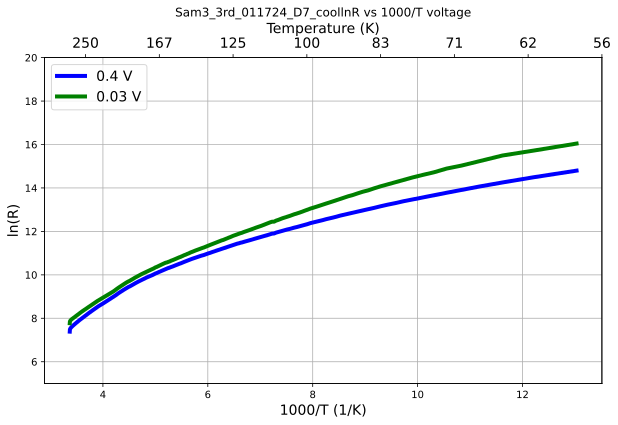

<Figure size 3000x1800 with 0 Axes>

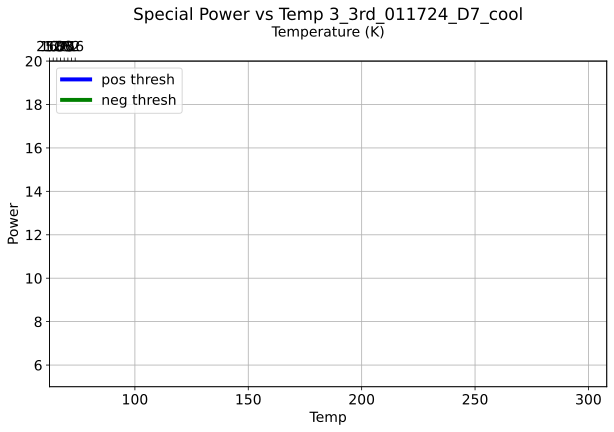

<Figure size 3000x1800 with 0 Axes>

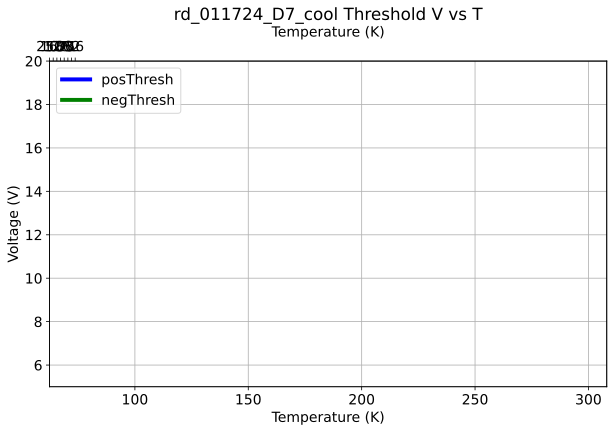

<Figure size 3000x1800 with 0 Axes>

self.data_to_graph[i][0]:  [18.685578839292013, 15.505959739001504, 13.497226100706383, 12.2145563530833, 11.384757611764973, 10.801781922435902, 10.35049117867745, 9.977884567639478, 9.65646498157812, 9.376978102833851, 9.134611981094093, 8.915910437718152, 8.719835690392118, 8.540242412218797, 8.369116537227818, 8.20765330018864, 8.05379354213008, 7.906981322879881, 7.767856972935271, 7.634185117537822, 7.509266152835118, 7.388709047710667, 7.272775669743547, 7.158740342322373, 7.048995488184703, 6.941312177324426, 6.837304827424375, 6.7348260244588, 6.636174110247491, 6.538990479916455, 6.444658908371451, 6.351697626164167, 6.261746841394867, 6.172567455977558, 6.086538958703351, 6.002045196900845, 5.921083269289416, 5.841884659757099, 5.765639939764053, 5.690566295851346, 5.617948333695457, 5.54631062606283, 5.476471503933544, 5.406769518742094, 5.33867941571784, 5.274652333818716, 5.2125415104001025, 5.149866390578896, 5.086639975710276, 5.021413693159134, 4.953900488226709, 4.882

/var/folders/y7/nfr2rwwn57jglbxxnjqph9dm0000gn/T/ipykernel_37572/299049523.py:1847: RuntimeWarning: divide by zero encountered in log
  resistance = np.log(IV_curve['R'][closest_index])
/var/folders/y7/nfr2rwwn57jglbxxnjqph9dm0000gn/T/ipykernel_37572/299049523.py:1847: RuntimeWarning: invalid value encountered in log
  resistance = np.log(IV_curve['R'][closest_index])


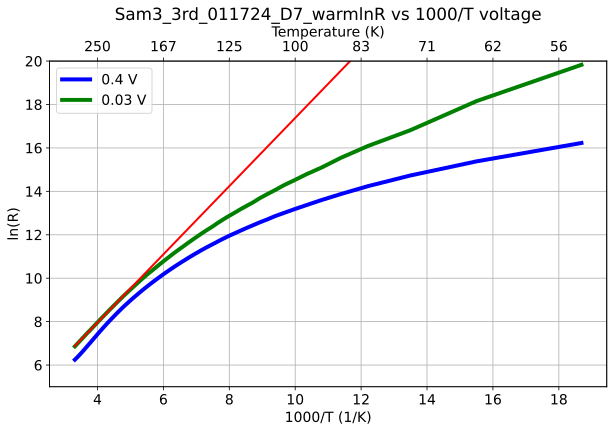

<Figure size 3000x1800 with 0 Axes>

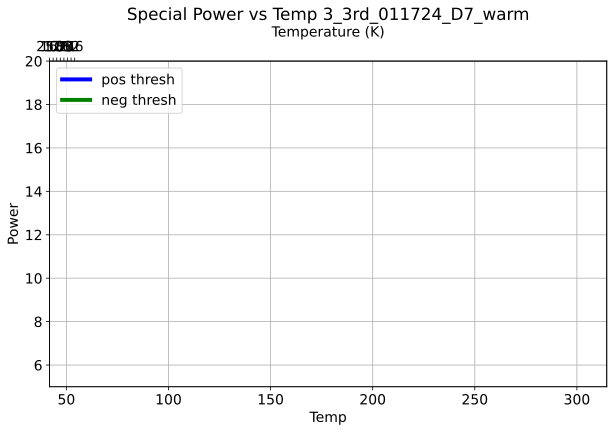

<Figure size 3000x1800 with 0 Axes>

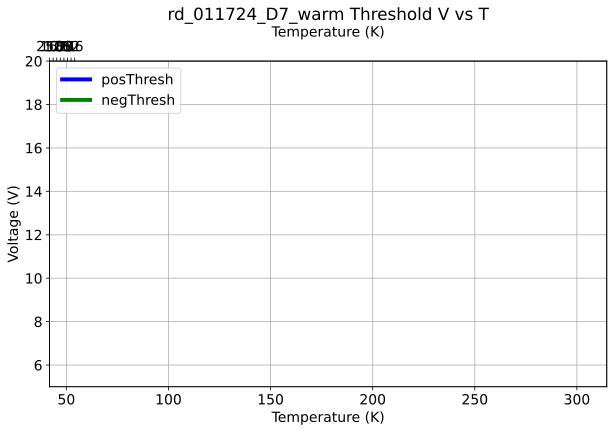

<Figure size 3000x1800 with 0 Axes>

In [6]:
# theFile = DataFile("c:/Users/Ted Mburu/Documents/GitHub/Nb02_v2/IVs_NbO2_Ti0_Sam3_052423_D15_cool.txt");
# print("path: ", os.getcwd() + "/summerData/IVs_NbO2_Ti0_2nd_Sam7_080823_D6_100K_5ms_0msbreak.txt")
# theFile = DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_2nd_Sam7_080823_D6_100K_5ms_0msbreak.txt")

# newest file: IVs_NbO2_Ti0_2nd_Sam2_053023_D13_cool

# theFiles = [
#     DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_2nd_Sam7_080823_D6_100K_5ms_0msbreak.txt"),
#     DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_2nd_Sam7_080823_D6_100K_50ms_0msbreak.txt"),
#     DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_2nd_Sam7_080823_D6_100K_100ms_0msbreak.txt"),
#     DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_2nd_Sam7_080823_D6_100K_100ms_100msbreak.txt"),
#     DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_2nd_Sam7_080823_D6_100K_500ms_500msbreak.txt"),
#     DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_2nd_Sam7_080823_D6_100K_500ms_1000msbreak.txt")
# ]

theFiles = [
    
    # DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_Sam12_061523_D14_cool.txt"),
    # DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_2nd_Sam17_062823_D1_cool.txt"),
    # DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_2nd_Sam7_080823_D6_warm.txt"),
    # DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_2nd_Sam7_080823_D6_cool_v2.txt"),
    # DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_2nd_Sam4_073023_D4_warm.txt"),
    # DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_2nd_Sam4_073023_D4_cool.txt"),
    # DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_2nd_Sam4_072723_D10_cool.txt"),
    # DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_Sam3_100223_D2_cool.txt"),
    # DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_Sam3_100323_D2_warm.txt"),
    # DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_KBSky1921ann_Sam22b_110623_D17.txt"),
    # DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_KBSky1921ann_Sam22b_110723_D1.txt"),
    # DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_KBSky1921unann_Sam23b_111523_D3.txt"),


    # DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_Sam15_2nd_111523_D3_cool.txt"),
    # DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_Sam15_2nd_112723_D2_cool.txt"),
    # DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_Sam15_2nd_112923_D4_cool.txt"),


    # DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_Sam12_061523_D14_cool.txt"),
    # DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_2nd_Sam17_062823_D1_cool.txt"),
    # DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_2nd_Sam7_080823_D6_warm.txt"),
    # DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_Sam15_2nd_112723_D2_cool.txt"),
    # DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_Sam15_2nd_112923_D4_cool.txt"),


    DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_Sam3_3rd_011724_D7_cool.txt"),
    DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_Sam3_3rd_011724_D7_warm.txt"),

    # IVs_NbO2_Ti0_Sam3_3rd_011724_D7_cool
    # IVs_NbO2_Ti0_Sam3_3rd_011724_D7_warm



# #new data: dec 2023 - jan 2024
#     # DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_Sam15_2nd_121823_D9_test.txt"),
#     # DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_Sam15_2nd_121823_D10_test.txt"),
#     # DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_Sam15_2nd_121823_D11_cool.txt"),
#     # DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_Sam15_2nd_121823_D11_test.txt"),
#     DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_Sam15_2nd_121823_D12_cool.txt"),
#     # DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_Sam15_2nd_121823_D12_test.txt"),
#     # DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_Sam15_2nd_122023_D13_test.txt"),
#     # DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_Sam15_2nd_122023_D14_test.txt"),
#     # DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_Sam15_2nd_122023_D15_test.txt"),
#     # DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_Sam15_2nd_122023_D16_test.txt"),
#     # DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_Sam15_2nd_122023_D17_cool.txt"),
#     DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_Sam15_2nd_122023_D17_test.txt"),
#     # DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_Sam15_2nd_122023_D17_warm.txt"),
#     # DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_Sam15_2nd_122023_D18_test.txt"),
#     DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_Sam15_2nd_122023_D19_cool.txt"),
#     DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_Sam15_2nd_122023_D19_test.txt"),
#     DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_Sam15_2nd_122023_D19_warm.txt"),
#     # DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_Sam15_2nd_122023_D20_test.txt"),
#     # DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_Sam15_2nd_122023_D21_test.txt"),
#     # DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_Sam15_2nd_122023_D22_test.txt"),
#     DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_Sam15_2nd_122223_D20_cool.txt"),
#     # DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_Sam15_2nd_122223_D20_warm.txt"),
#     # DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_Sam15_2nd_122223_D21_cool.txt"),
#     # DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_Sam15_2nd_122223_D21_warm.txt"),
#     # DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_Sam3_3rd_011024_D4_cool.txt"),
#     # DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_Sam3_3rd_011124_D4_warm.txt"),
#     DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_Sam3_3rd_011124_D16_cool.txt"),
#     # DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_Sam3_3rd_011124_D16_warm.txt"),
#     DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_Sam3_3rd_011224_D17_cool.txt"),
#     DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_Sam3_3rd_011224_D17_warm.txt"),
#     # DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_Sam3_3rd_011324_D18_cool.txt"),
#     DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_Sam3_3rd_011424_D19_cool.txt"),
#     DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_Sam3_3rd_011424_D19_warm.txt"),







    # DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_2nd_Sam7_080823_D6_cool_v2.txt"),
    # DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_2nd_Sam4_073023_D4_warm.txt"),
    # DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_2nd_Sam4_073023_D4_cool.txt"),
    # DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_2nd_Sam4_072723_D10_cool.txt"),
    # DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_Sam3_100223_D2_cool.txt"),
    # DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_Sam3_100323_D2_warm.txt"),
    # DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_KBSky1921ann_Sam22b_110623_D17.txt"),
    # DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_KBSky1921ann_Sam22b_110723_D1.txt"),
    # DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_KBSky1921unann_Sam23b_111523_D3.txt"),


    # DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_Sam15_2nd_111523_D3_cool.txt"),
    # DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_Sam15_2nd_112723_D2_cool.txt"),
    # DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_Sam15_2nd_112923_D4_cool.txt"),


    # DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_Sam15_2nd_111523_D3_cool.txt"),
    # DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_Sam15_2nd_112723_D2_cool.txt"),
    # DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_Sam15_2nd_112923_D4_cool.txt"),

    

]






























# theFiles[0].graph_all_data()
# theFiles[0].graph_resistance_vs_temp()

# data_to_graph = theFiles[0].return_resistances_at_current(1e-4)

# the_graph = Graph(
#             "R at I: " + theFiles[0].file_name[13:-4],   # title
#             "Type of Data",                             # xlabel
#             "Voltage (V)",                          # ylabel
#             [],                                     # hlines
#             "plot",                                  # type of graph
#             [data_to_graph],                          # data to graph
#             [],                                     # points
#         )

for file in theFiles:
    # file.graph_all_data()
    file.graph_log_r_vs_1_over_temp_by_voltage()
    # file.overlay_IV_curves(5)
    file.graph_special_power_vs_temp()
    # file.graph_delta_v_vs_time()

    # file.graph_log_r_vs_1_over_temp()
    # file.graph_combined_log_r_vs_1_over_temp()

    # file.graph_combined_log_r_vs_1_over_temp_vs_p("current")
    # file.graph_combined_log_r_vs_1_over_temp_vs_p("voltage")
    

    # file.graph_DV_DI_vs_I()
    # file.graph_dR_vs_I()
    # file.graph_lowest_voltage_resistance()
    # file.graph_voltage_vs_resistance_half_volt()
    # file.graph_time_vs_I()
    # file.graph_delta_v_vs_temp()
    file.graph_voltage_vs_temp_type()
    # file.graph_power_vs_temp()

    # file.graph_log_r_vs_voltage()
    # file.graph_r_vs_log_i()
    # file.graph_R_vs_T_constant_P()

    
    # file.graph_voltage_vs_temp()
    # data_to_graph.append(file.return_voltage_vs_temp())
    # file.graph_voltage_vs_temp()







asdf